In [465]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped#, PURankingLoss
from data_loader import *
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


# Prepare data

In [466]:
dataset = Epilepsy2Dataset()
X, y = dataset.data.numpy(), dataset.labels.numpy()
X.shape

(11500, 178)

In [467]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, stratify=y_train_val, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (8050, 178) (8050,)
Validation: (1150, 178) (1150,)
Test: (2300, 178) (2300,)


In [468]:
positive_class=1
unlabeled_fraction = 0.5

In [469]:
y_train_pu, unlabeled_idx_train = make_pu_labels(y_train, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
y_val_pu, unlabeled_idx_val = make_pu_labels(y_val, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
y_test_pu, unlabeled_idx_test = make_pu_labels(y_test, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
print((y_train[y_train == 1]).shape)
print((y_train_pu[y_train_pu == 1]).shape)
print((y_val[y_val == 1]).shape)
print((y_val_pu[y_val_pu == 1]).shape)
print((y_test[y_test == 1]).shape)
print((y_test_pu[y_test_pu == 1]).shape)

(1610,)
(805,)
(230,)
(115,)
(460,)
(230,)


In [470]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_pu_tensor = torch.tensor(y_train_pu, dtype=torch.long)
y_test_pu_tensor = torch.tensor(y_test_pu, dtype=torch.long)
y_val_pu_tensor = torch.tensor(y_val_pu, dtype=torch.long)

# InceptionTime + AsymLoss

In [471]:
from pu_loss import PUAsymLoss_Direct, PUAsymLoss_CE

In [472]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.tracker import SaveModelCallback

# Try PU problem with CrossEntropyLoss

from sklearn.metrics import f1_score, precision_score
from tsai.metrics import skm_to_fastai

f1_macro = skm_to_fastai(f1_score, average="macro")
precision_macro = skm_to_fastai(precision_score, average="macro")

criterion = PUAsymLoss_CE(gamma=0.9)

X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))



tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)


In [473]:
clf.load("epilepsy_inctime_asymloss_gamma_0.1")

In [474]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(9200, 1, 178)

In [475]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9870    0.9891    0.9881      6440
           1     0.9561    0.9478    0.9520      1610

    accuracy                         0.9809      8050
   macro avg     0.9716    0.9685    0.9700      8050
weighted avg     0.9808    0.9809    0.9808      8050

[[6370   70]
 [  84 1526]]


In [476]:
logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9881    0.9924    0.9902       920
           1     0.9690    0.9522    0.9605       230

    accuracy                         0.9843      1150
   macro avg     0.9786    0.9723    0.9754      1150
weighted avg     0.9843    0.9843    0.9843      1150

[[913   7]
 [ 11 219]]


In [477]:
# Test metrics
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9886    0.9870    0.9878      1840
           1     0.9482    0.9543    0.9512       460

    accuracy                         0.9804      2300
   macro avg     0.9684    0.9707    0.9695      2300
weighted avg     0.9805    0.9804    0.9805      2300

[[1816   24]
 [  21  439]]


In [478]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 722
In percentage: 0.8969
Test
Total number of true positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 220
In percentage: 0.9565
Val
Total number of true positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 109
In percentage: 0.9478


## Calibration

In [479]:
from calibration import *
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import torch, torch.nn.functional as F


In [480]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.8496407e-01, 1.5035919e-02],
       [9.4202834e-01, 5.7971697e-02],
       [9.9219513e-01, 7.8048469e-03],
       ...,
       [4.2329538e-03, 9.9576700e-01],
       [1.8668926e-04, 9.9981338e-01],
       [9.9634969e-01, 3.6503305e-03]], shape=(2300, 2), dtype=float32)

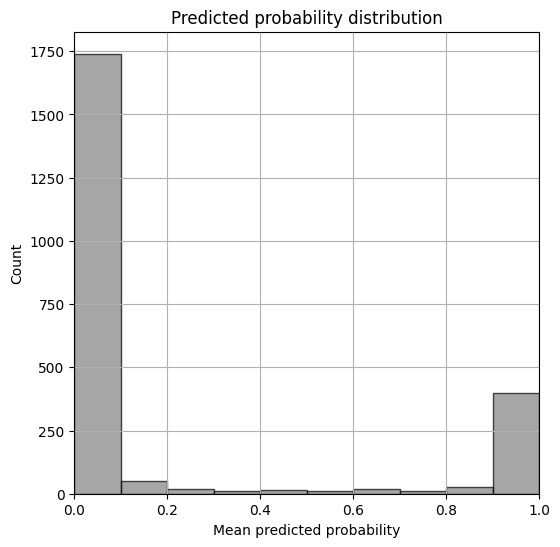

In [481]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

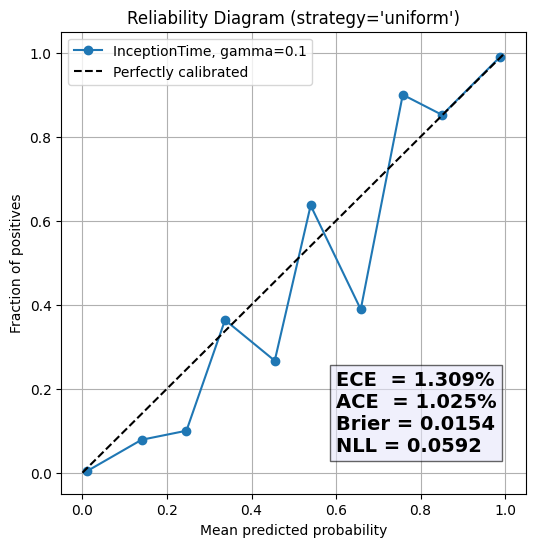

In [482]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

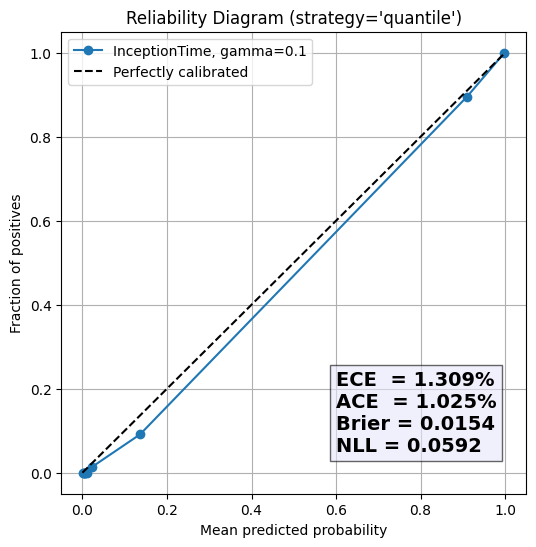

In [483]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

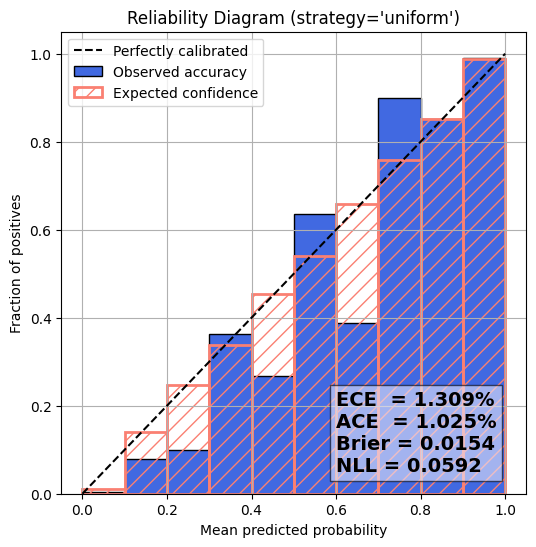

In [484]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [485]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_all[splits[1]])

Optimal temperature: 0.758


ModelWithTemperature()

In [486]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

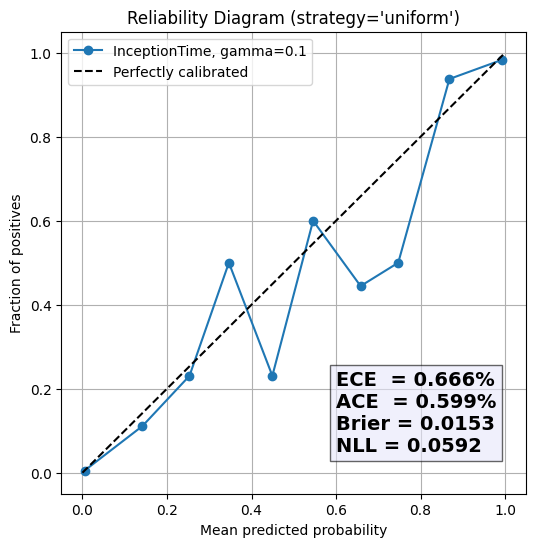

In [487]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

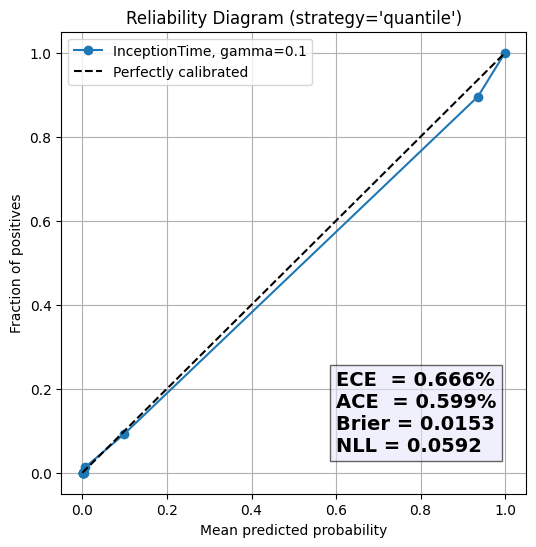

In [488]:
# strategy='quantile' -> equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [210]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00666
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    23 | [  0.500,   0.600] |      0.549  |      0.696 |       0.147  |     0.00147
 6  |    15 | [  0.600,   0.700] |      0.656  |      0.467 |       0.190  |     0.00124
 7  |    27 | [  0.700,   0.800] |      0.747  |      0.630 |       0.117  |     0.00138
 8  |    43 | [  0.800,   0.900] |      0.862  |      0.907 |       0.045  |     0.00084
 9  |  2192 | [  0.900,   1.000] |      0.995  |      0.993 |       0.002  |     0.00174


In [207]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00599

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00111] |    0.000   |   0.000  |    0.000
 1  |   230 | [0.00112, 0.47021] |    0.064   |   0.104  |    0.040
 2  |   230 | [0.47535, 0.98758] |    0.902   |   0.909  |    0.007
 3  |   230 | [0.98760, 0.99631] |    0.993   |   0.987  |    0.006
 4  |   230 | [0.99631, 0.99813] |    0.997   |   1.000  |    0.003
 5  |   230 | [0.99813, 0.99881] |    0.999   |   1.000  |    0.001
 6  |   230 | [0.99881, 0.99918] |    0.999   |   1.000  |    0.001
 7  |   230 | [0.99918, 0.99941] |    0.999   |   1.000  |    0.001
 8  |   230 | [0.99941, 0.99958] |    0.999   |   1.000  |    0.001
 9  |   230 | [0.99958, 0.99987] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt scaling

In [489]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

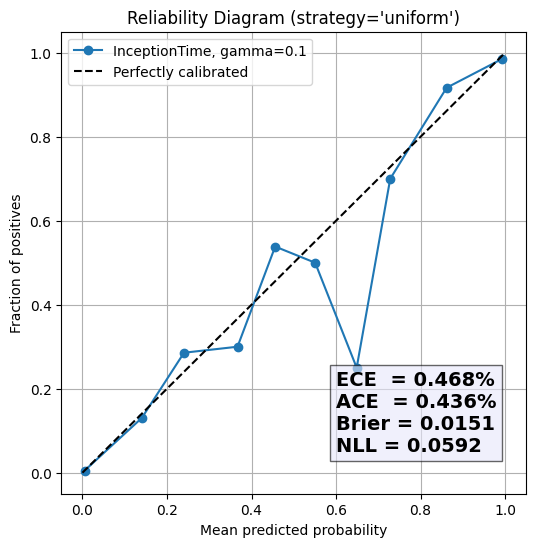

In [490]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

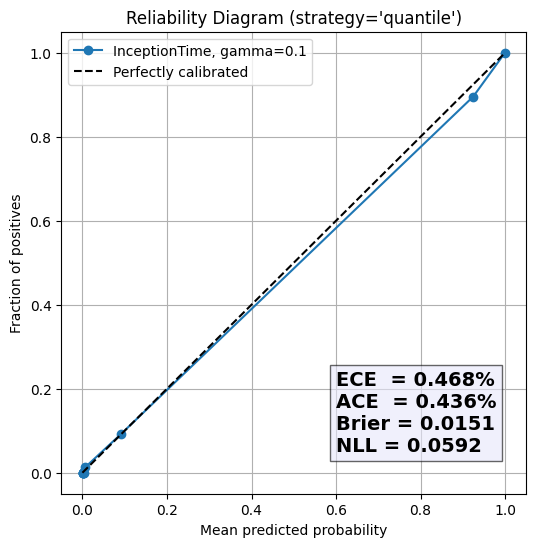

In [491]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [492]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00468
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    19 | [  0.500,   0.600] |      0.546  |      0.474 |       0.072  |     0.00060
 6  |    22 | [  0.600,   0.700] |      0.642  |      0.455 |       0.187  |     0.00179
 7  |    24 | [  0.700,   0.800] |      0.747  |      0.708 |       0.038  |     0.00040
 8  |    47 | [  0.800,   0.900] |      0.861  |      0.894 |       0.033  |     0.00068
 9  |  2188 | [  0.900,   1.000] |      0.994  |      0.993 |       0.001  |     0.00121


In [493]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00436

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00163] |    0.000   |   0.000  |    0.000
 1  |   230 | [0.00165, 0.51137] |    0.075   |   0.104  |    0.029
 2  |   230 | [0.51635, 0.98775] |    0.910   |   0.909  |    0.001
 3  |   230 | [0.98777, 0.99621] |    0.993   |   0.987  |    0.006
 4  |   230 | [0.99621, 0.99804] |    0.997   |   1.000  |    0.003
 5  |   230 | [0.99804, 0.99873] |    0.998   |   1.000  |    0.002
 6  |   230 | [0.99873, 0.99911] |    0.999   |   1.000  |    0.001
 7  |   230 | [0.99911, 0.99935] |    0.999   |   1.000  |    0.001
 8  |   230 | [0.99935, 0.99954] |    0.999   |   1.000  |    0.001
 9  |   230 | [0.99954, 0.99985] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [495]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


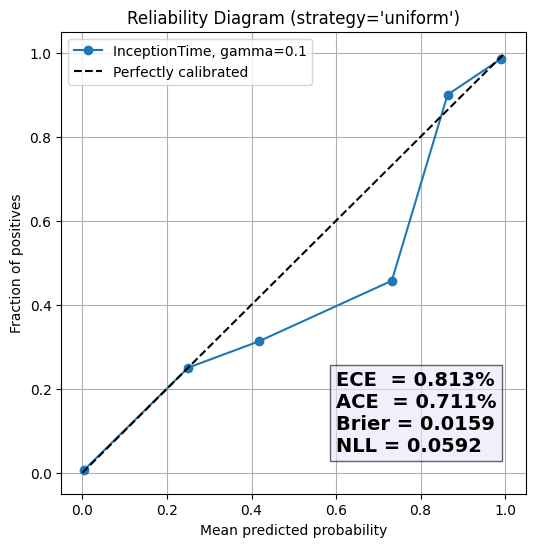

In [497]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

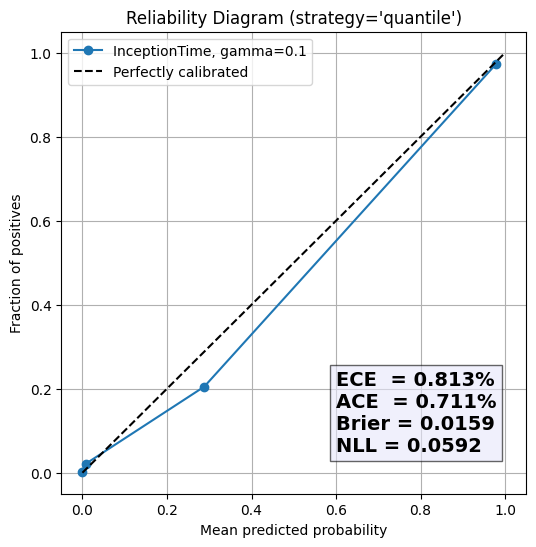

In [498]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [499]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00813
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    16 | [  0.500,   0.600] |      0.583  |      0.688 |       0.104  |     0.00072
 7  |    39 | [  0.700,   0.800] |      0.734  |      0.487 |       0.247  |     0.00418
 8  |    30 | [  0.800,   0.900] |      0.864  |      0.900 |       0.036  |     0.00047
 9  |  2215 | [  0.900,   1.000] |      0.994  |      0.991 |       0.003  |     0.00275


In [500]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00711

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00000] |    0.000   |   0.004  |    0.004
 1  |   230 | [0.00000, 0.27273] |    0.065   |   0.096  |    0.030
 2  |   230 | [0.27273, 0.99213] |    0.906   |   0.926  |    0.020
 3  |   230 | [0.99213, 1.00000] |    0.995   |   0.978  |    0.016
 4  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 9  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Mamba + AsymLoss

In [504]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

torch.Size([8050, 1, 178])
in_channel: 1, sequence_length: 178, n_output: 2


In [505]:
from pu_loss import PUAsymLoss_Direct, PUAsymLoss_CE
from baseline import Mamba2Classifier, train
criterion = PUAsymLoss_CE(gamma=0.1)
print(X_train_tensor.shape)

torch.Size([8050, 1, 178])


In [506]:
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [507]:
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_convproj_AsymLoss_0.1.pth", weights_only=True))

<All keys matched successfully>

In [508]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([2300, 178, 1])
torch.Size([8050, 178, 1])


In [509]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9821    0.9809    0.9815      6440
           1     0.9240    0.9286    0.9263      1610

    accuracy                         0.9704      8050
   macro avg     0.9531    0.9547    0.9539      8050
weighted avg     0.9705    0.9704    0.9705      8050

[[6317  123]
 [ 115 1495]]


In [510]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9773    0.9826    0.9799       920
           1     0.9289    0.9087    0.9187       230

    accuracy                         0.9678      1150
   macro avg     0.9531    0.9457    0.9493      1150
weighted avg     0.9676    0.9678    0.9677      1150

[[904  16]
 [ 21 209]]


In [511]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9778    0.9804    0.9791      1840
           1     0.9209    0.9109    0.9158       460

    accuracy                         0.9665      2300
   macro avg     0.9493    0.9457    0.9475      2300
weighted avg     0.9664    0.9665    0.9665      2300

[[1804   36]
 [  41  419]]


In [512]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 704
In percentage: 0.8745
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 104
In percentage: 0.9043
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 209
In percentage: 0.9087


## Calibration

In [513]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.9925405e-01, 7.4591453e-04],
       [9.5436794e-01, 4.5632001e-02],
       [9.9985886e-01, 1.4107476e-04],
       ...,
       [7.5978125e-05, 9.9992406e-01],
       [3.6683101e-05, 9.9996328e-01],
       [9.9999642e-01, 3.5441280e-06]], shape=(2300, 2), dtype=float32)

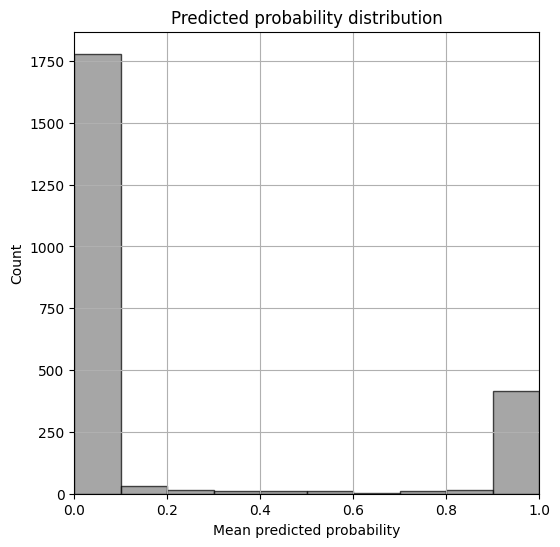

In [514]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

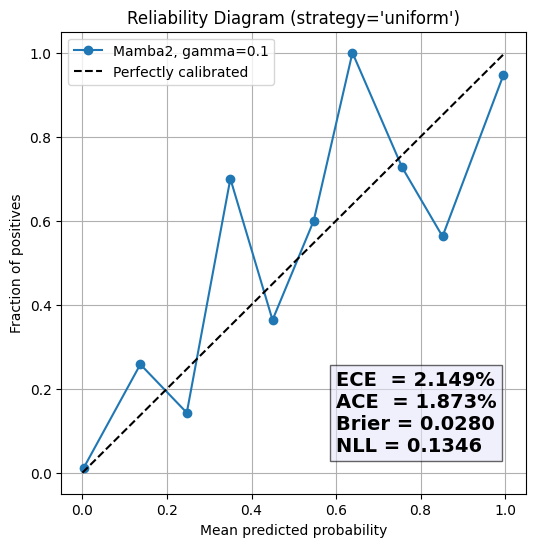

In [515]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

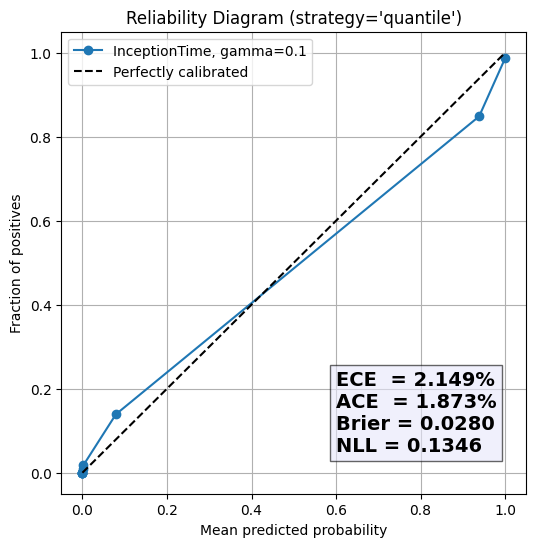

In [516]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

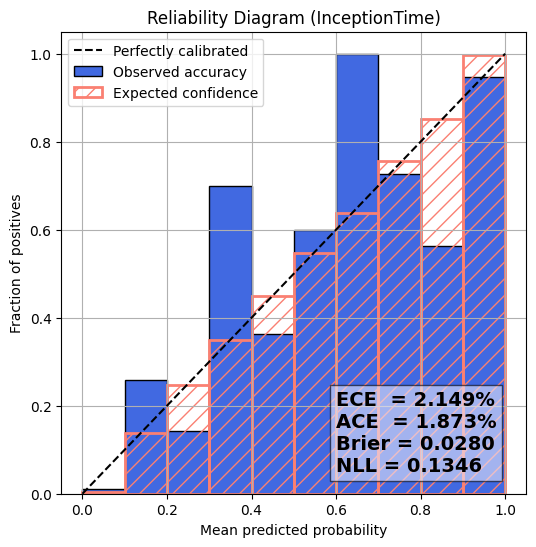

In [517]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [518]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_all[splits[1]])

Optimal temperature: 1.861


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [519]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

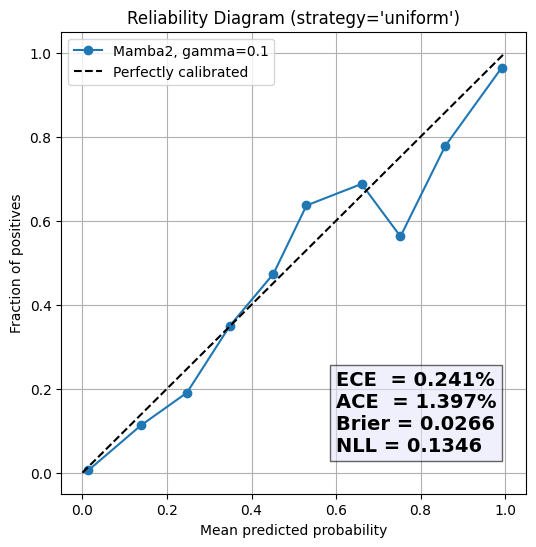

In [520]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

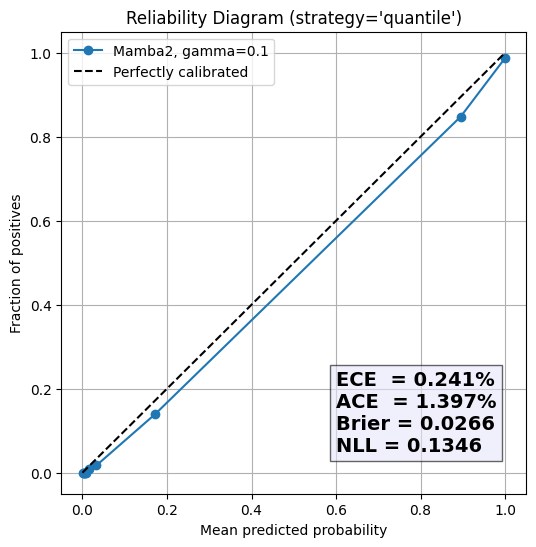

In [521]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [522]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00241
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    30 | [  0.500,   0.600] |      0.541  |      0.567 |       0.025  |     0.00033
 6  |    36 | [  0.600,   0.700] |      0.655  |      0.667 |       0.011  |     0.00018
 7  |    58 | [  0.700,   0.800] |      0.753  |      0.741 |       0.011  |     0.00029
 8  |    98 | [  0.800,   0.900] |      0.861  |      0.857 |       0.004  |     0.00015
 9  |  2078 | [  0.900,   1.000] |      0.987  |      0.989 |       0.002  |     0.00147


In [523]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01397

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00002, 0.00145] |    0.000   |   0.013  |    0.013
 1  |   230 | [0.00146, 0.52627] |    0.105   |   0.152  |    0.047
 2  |   230 | [0.52950, 0.94611] |    0.828   |   0.861  |    0.033
 3  |   230 | [0.94612, 0.97843] |    0.967   |   0.983  |    0.016
 4  |   230 | [0.97845, 0.98831] |    0.984   |   0.991  |    0.007
 5  |   230 | [0.98835, 0.99258] |    0.991   |   1.000  |    0.009
 6  |   230 | [0.99258, 0.99477] |    0.994   |   1.000  |    0.006
 7  |   230 | [0.99477, 0.99634] |    0.996   |   1.000  |    0.004
 8  |   230 | [0.99635, 0.99767] |    0.997   |   1.000  |    0.003
 9  |   230 | [0.99767, 0.99932] |    0.998   |   1.000  |    0.002

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [524]:
from sklearn.linear_model import LogisticRegression
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

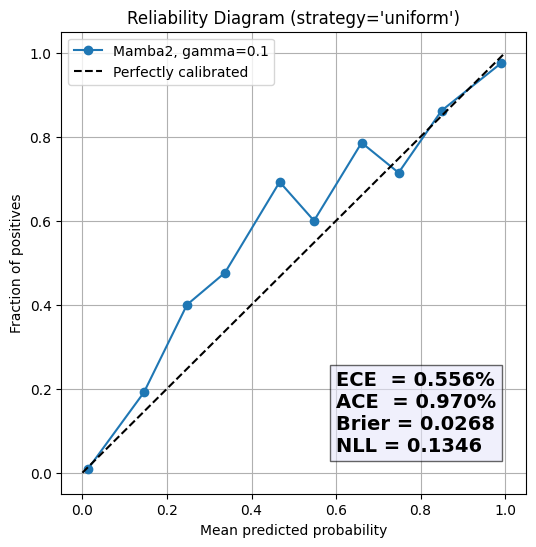

In [525]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

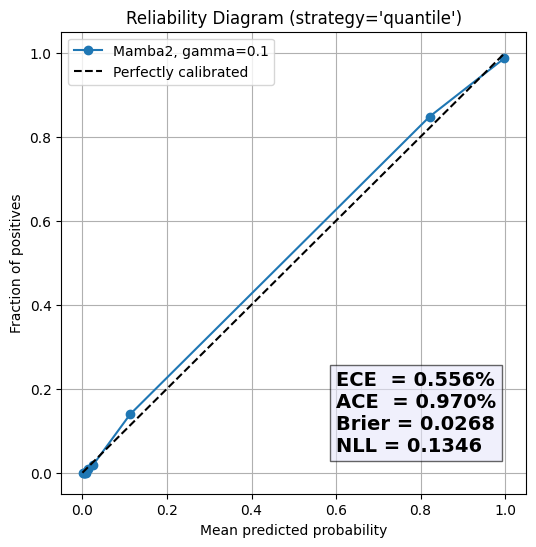

In [526]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [527]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00556
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    28 | [  0.500,   0.600] |      0.541  |      0.464 |       0.077  |     0.00094
 6  |    35 | [  0.600,   0.700] |      0.662  |      0.629 |       0.033  |     0.00051
 7  |    46 | [  0.700,   0.800] |      0.750  |      0.652 |       0.098  |     0.00197
 8  |    97 | [  0.800,   0.900] |      0.853  |      0.825 |       0.028  |     0.00119
 9  |  2094 | [  0.900,   1.000] |      0.988  |      0.989 |       0.001  |     0.00095


In [528]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00970

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00011, 0.00565] |    0.002   |   0.013  |    0.011
 1  |   230 | [0.00569, 0.68227] |    0.179   |   0.152  |    0.027
 2  |   230 | [0.68478, 0.96197] |    0.887   |   0.861  |    0.026
 3  |   230 | [0.96198, 0.98336] |    0.976   |   0.983  |    0.007
 4  |   230 | [0.98337, 0.99039] |    0.987   |   0.991  |    0.004
 5  |   230 | [0.99042, 0.99360] |    0.992   |   1.000  |    0.008
 6  |   230 | [0.99360, 0.99532] |    0.995   |   1.000  |    0.005
 7  |   230 | [0.99532, 0.99660] |    0.996   |   1.000  |    0.004
 8  |   230 | [0.99661, 0.99773] |    0.997   |   1.000  |    0.003
 9  |   230 | [0.99773, 0.99924] |    0.998   |   1.000  |    0.002

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [529]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


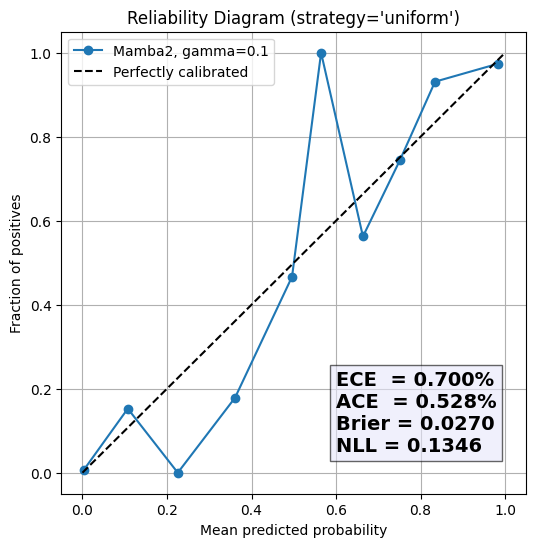

In [530]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [531]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [532]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00700
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |    55 | [  0.400,   0.500] |      0.500  |      0.527 |       0.027  |     0.00065
 5  |     8 | [  0.500,   0.600] |      0.555  |      0.750 |       0.195  |     0.00068
 6  |    44 | [  0.600,   0.700] |      0.648  |      0.727 |       0.079  |     0.00152
 7  |    46 | [  0.700,   0.800] |      0.753  |      0.761 |       0.008  |     0.00016
 8  |    88 | [  0.800,   0.900] |      0.873  |      0.875 |       0.002  |     0.00006
 9  |  2059 | [  0.900,   1.000] |      0.995  |      0.990 |       0.004  |     0.00393


In [533]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00528

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.01754] |    0.007   |   0.009  |    0.002
 1  |   230 | [0.01754, 0.50000] |    0.167   |   0.174  |    0.007
 2  |   230 | [0.50000, 0.96429] |    0.828   |   0.843  |    0.016
 3  |   230 | [0.96429, 1.00000] |    0.998   |   1.000  |    0.002
 4  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 5  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 9  |   230 | [1.00000, 1.00000] |    1.000   |   0.991  |    0.009

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + AsymLoss

In [534]:
from baseline import Conv_Net, train
model = Conv_Net(in_channel, seq_length, n_hidden, n_output, dropout=0.1)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5696, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5696, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [535]:
model.load_state_dict(torch.load("models/epilepsy_cnn_asymloss_0.1.pth"))

<All keys matched successfully>

In [536]:
model.eval()
logits_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(logits_train, 1)[1]

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9737    0.9675    0.9706      6440
           1     0.8734    0.8957    0.8844      1610

    accuracy                         0.9532      8050
   macro avg     0.9236    0.9316    0.9275      8050
weighted avg     0.9537    0.9532    0.9534      8050

[[6231  209]
 [ 168 1442]]


In [537]:
model.eval()
logits_val = model(X_val_tensor.to(device)).cpu().detach()
preds_val = torch.max(logits_val, 1)[1]

print(classification_report(y_val, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9750    0.9761    0.9756       920
           1     0.9039    0.9000    0.9020       230

    accuracy                         0.9609      1150
   macro avg     0.9395    0.9380    0.9388      1150
weighted avg     0.9608    0.9609    0.9608      1150

[[898  22]
 [ 23 207]]


In [538]:
model.eval()
logits_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.max(logits_test, 1)[1]

print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9717    0.9701    0.9709      1840
           1     0.8812    0.8870    0.8841       460

    accuracy                         0.9535      2300
   macro avg     0.9265    0.9285    0.9275      2300
weighted avg     0.9536    0.9535    0.9535      2300

[[1785   55]
 [  52  408]]


In [539]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 712
In percentage: 0.8845
Test
Total number of true positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 206
In percentage: 0.8957
Val
Total number of true positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 104
In percentage: 0.9043


## Calibration

In [540]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[8.3329922e-01, 1.6670085e-01],
       [6.4796561e-01, 3.5203436e-01],
       [8.5087395e-01, 1.4912607e-01],
       ...,
       [2.1467984e-06, 9.9999785e-01],
       [1.7776628e-03, 9.9822229e-01],
       [9.0752965e-01, 9.2470363e-02]], shape=(2300, 2), dtype=float32)

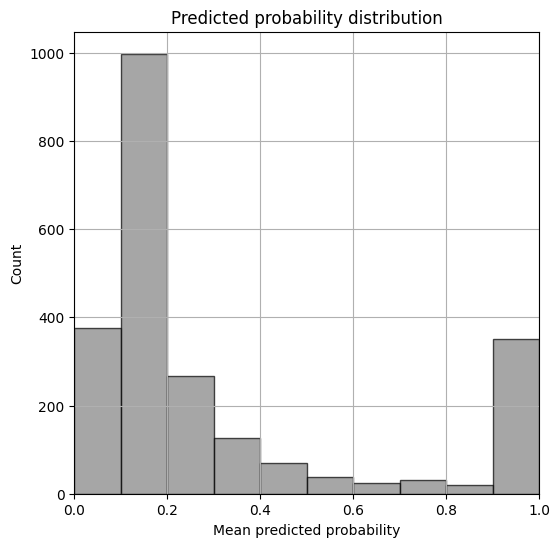

In [541]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

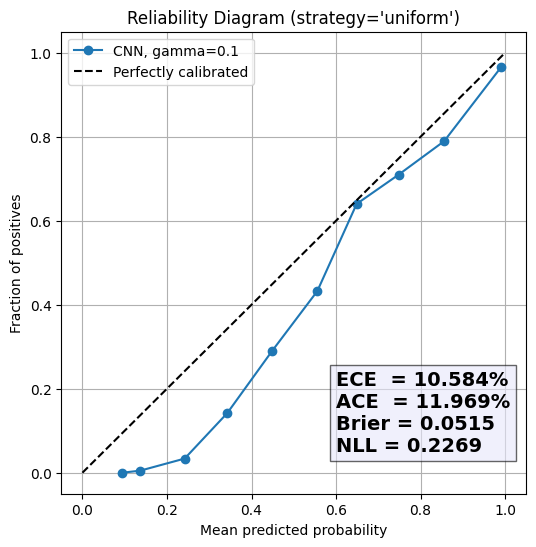

In [542]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [543]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

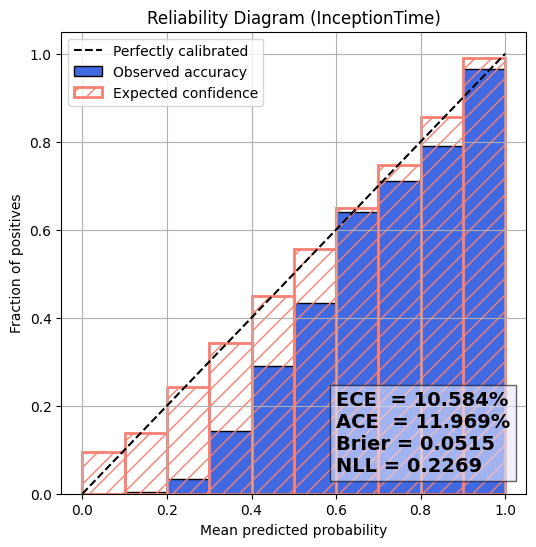

In [301]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [544]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.490


ModelWithTemperature()

In [545]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

In [546]:
print(confusion_matrix(y_test, (y_prob_after[:, 1] > 0.5).astype(int)))

[[1785   55]
 [  52  408]]


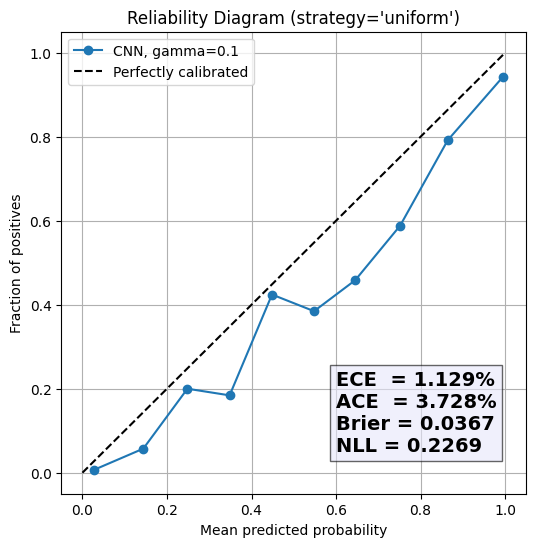

In [547]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

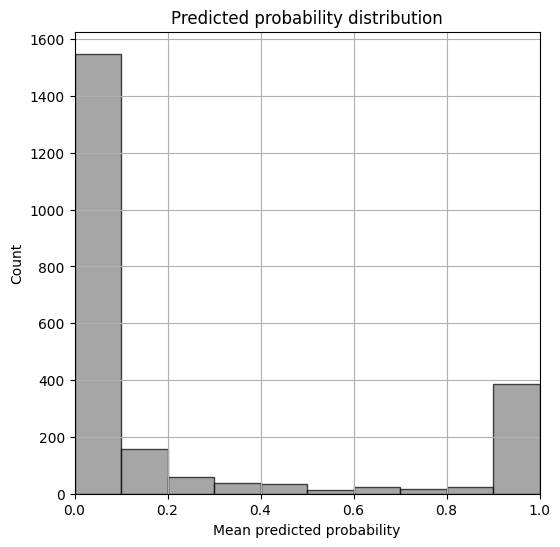

In [548]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

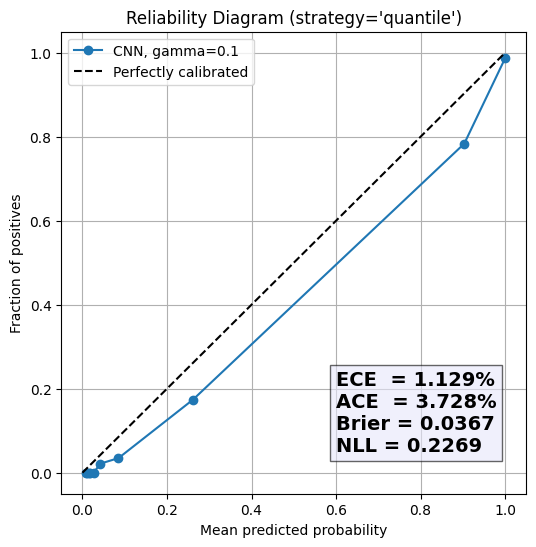

In [549]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [550]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01129
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    46 | [  0.500,   0.600] |      0.551  |      0.522 |       0.029  |     0.00058
 6  |    62 | [  0.600,   0.700] |      0.649  |      0.677 |       0.028  |     0.00076
 7  |    77 | [  0.700,   0.800] |      0.752  |      0.753 |       0.002  |     0.00006
 8  |   181 | [  0.800,   0.900] |      0.857  |      0.923 |       0.066  |     0.00516
 9  |  1934 | [  0.900,   1.000] |      0.978  |      0.983 |       0.006  |     0.00474


In [551]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.03728

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00000] |    0.000   |   0.013  |    0.013
 1  |   230 | [0.00000, 0.47279] |    0.097   |   0.217  |    0.120
 2  |   230 | [0.48293, 0.87019] |    0.739   |   0.826  |    0.088
 3  |   230 | [0.87029, 0.94343] |    0.915   |   0.965  |    0.051
 4  |   230 | [0.94358, 0.96766] |    0.957   |   0.978  |    0.021
 5  |   230 | [0.96774, 0.97814] |    0.973   |   1.000  |    0.027
 6  |   230 | [0.97826, 0.98339] |    0.981   |   1.000  |    0.019
 7  |   230 | [0.98340, 0.98743] |    0.986   |   1.000  |    0.014
 8  |   230 | [0.98744, 0.99022] |    0.989   |   1.000  |    0.011
 9  |   230 | [0.99023, 0.99071] |    0.990   |   1.000  |    0.010

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [552]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

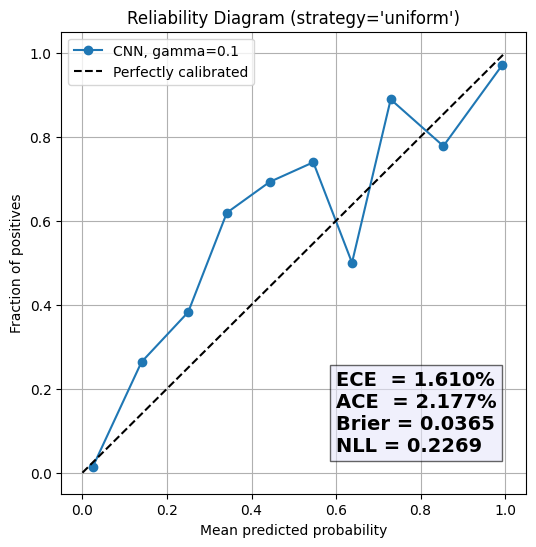

In [553]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [554]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [555]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01610
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    36 | [  0.500,   0.600] |      0.550  |      0.583 |       0.033  |     0.00052
 6  |    27 | [  0.600,   0.700] |      0.654  |      0.407 |       0.246  |     0.00289
 7  |    43 | [  0.700,   0.800] |      0.746  |      0.674 |       0.071  |     0.00133
 8  |   128 | [  0.800,   0.900] |      0.859  |      0.742 |       0.117  |     0.00652
 9  |  2066 | [  0.900,   1.000] |      0.979  |      0.984 |       0.005  |     0.00485


In [556]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.02177

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00069] |    0.000   |   0.013  |    0.013
 1  |   230 | [0.00069, 0.78504] |    0.272   |   0.217  |    0.055
 2  |   230 | [0.78981, 0.93724] |    0.890   |   0.826  |    0.064
 3  |   230 | [0.93727, 0.96583] |    0.954   |   0.965  |    0.011
 4  |   230 | [0.96590, 0.97704] |    0.972   |   0.978  |    0.006
 5  |   230 | [0.97708, 0.98258] |    0.980   |   1.000  |    0.020
 6  |   230 | [0.98265, 0.98564] |    0.984   |   1.000  |    0.016
 7  |   230 | [0.98564, 0.98819] |    0.987   |   1.000  |    0.013
 8  |   230 | [0.98819, 0.99009] |    0.989   |   1.000  |    0.011
 9  |   230 | [0.99009, 0.99044] |    0.990   |   1.000  |    0.010

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [557]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


In [558]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [559]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [560]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01045
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |     4 | [  0.400,   0.500] |      0.500  |      0.500 |       0.000  |     0.00000
 5  |    50 | [  0.500,   0.600] |      0.556  |      0.420 |       0.136  |     0.00295
 6  |    74 | [  0.600,   0.700] |      0.667  |      0.635 |       0.032  |     0.00103
 7  |    83 | [  0.700,   0.800] |      0.776  |      0.807 |       0.031  |     0.00113
 8  |   146 | [  0.800,   0.900] |      0.861  |      0.890 |       0.030  |     0.00189
 9  |  1943 | [  0.900,   1.000] |      0.993  |      0.989 |       0.004  |     0.00345


In [561]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01100

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.05000] |    0.003   |   0.013  |    0.010
 1  |   230 | [0.05000, 0.44444] |    0.201   |   0.222  |    0.021
 2  |   230 | [0.44444, 0.90909] |    0.777   |   0.822  |    0.045
 3  |   230 | [0.90909, 1.00000] |    0.975   |   0.974  |    0.001
 4  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.983  |    0.017
 9  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# InceptionTime + CE Loss

In [321]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.tracker import SaveModelCallback

# Try PU problem with CrossEntropyLoss

from sklearn.metrics import f1_score, precision_score
from tsai.metrics import skm_to_fastai

f1_macro = skm_to_fastai(f1_score, average="macro")
precision_macro = skm_to_fastai(precision_score, average="macro")

criterion = nn.CrossEntropyLoss()

X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val_pu])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))

classes = np.unique(y_all)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_all[splits[0]])
ce_weight = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)


In [322]:
clf.load("epilepsy_inctime_entropy") 


In [323]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(9200, 1, 178)

In [324]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9848    0.9891    0.9870      6440
           1     0.9558    0.9391    0.9474      1610

    accuracy                         0.9791      8050
   macro avg     0.9703    0.9641    0.9672      8050
weighted avg     0.9790    0.9791    0.9791      8050

[[6370   70]
 [  98 1512]]


In [325]:
# Val metrics

logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9891    0.9891    0.9891       920
           1     0.9565    0.9565    0.9565       230

    accuracy                         0.9826      1150
   macro avg     0.9728    0.9728    0.9728      1150
weighted avg     0.9826    0.9826    0.9826      1150

[[910  10]
 [ 10 220]]


In [326]:
# Test metrics
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9870    0.9870    0.9870      1840
           1     0.9478    0.9478    0.9478       460

    accuracy                         0.9791      2300
   macro avg     0.9674    0.9674    0.9674      2300
weighted avg     0.9791    0.9791    0.9791      2300

[[1816   24]
 [  24  436]]


In [327]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 747
In percentage: 0.9280
Test
Total number of true positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 220
In percentage: 0.9565
Val
Total number of true positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 111
In percentage: 0.9652


## Calibration

In [328]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.98556817, 0.01443182],
       [0.96448827, 0.03551174],
       [0.98935694, 0.0106431 ],
       ...,
       [0.12293681, 0.8770632 ],
       [0.30076602, 0.699234  ],
       [0.99725085, 0.00274917]], shape=(2300, 2), dtype=float32)

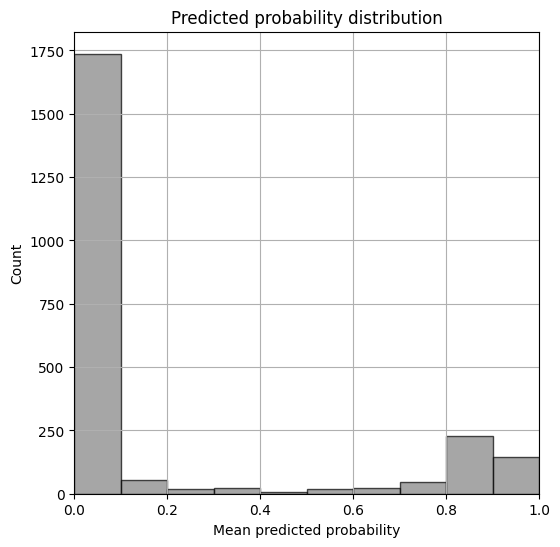

In [329]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

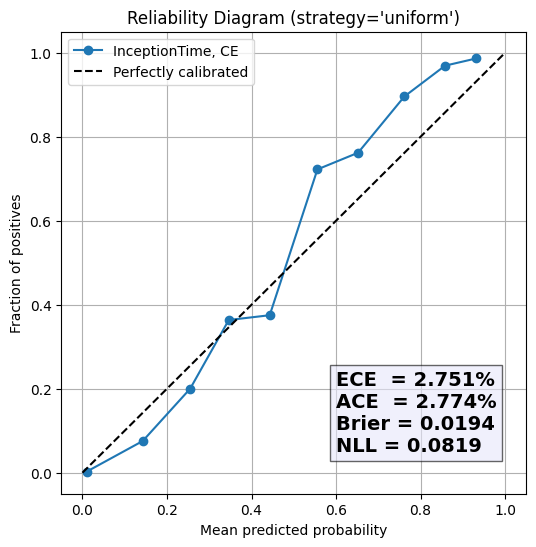

In [330]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

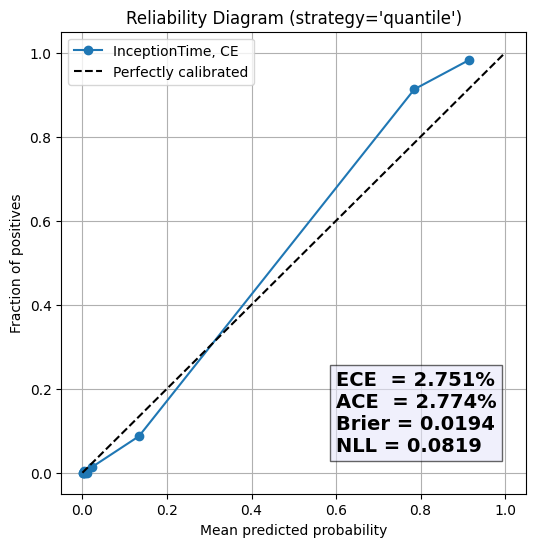

In [331]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

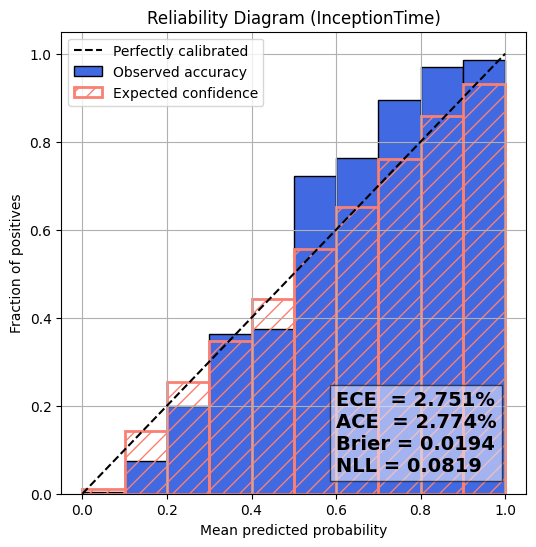

In [332]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [334]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.614


ModelWithTemperature()

In [335]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

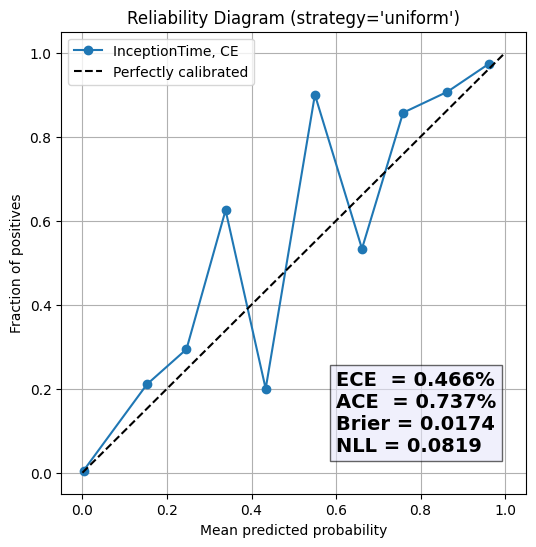

In [337]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

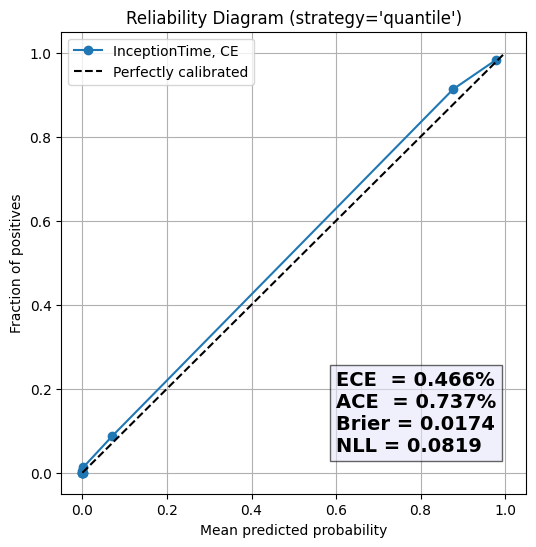

In [338]:
# strategy='quantile' -> equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [339]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00466
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    15 | [  0.500,   0.600] |      0.555  |      0.867 |       0.311  |     0.00203
 6  |    23 | [  0.600,   0.700] |      0.661  |      0.478 |       0.183  |     0.00183
 7  |    31 | [  0.700,   0.800] |      0.756  |      0.774 |       0.018  |     0.00025
 8  |    62 | [  0.800,   0.900] |      0.858  |      0.871 |       0.013  |     0.00034
 9  |  2169 | [  0.900,   1.000] |      0.991  |      0.991 |       0.000  |     0.00022


In [340]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00737

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00100, 0.04176] |    0.022   |   0.017  |    0.005
 1  |   230 | [0.04214, 0.49749] |    0.123   |   0.087  |    0.036
 2  |   230 | [0.54758, 0.99565] |    0.930   |   0.913  |    0.017
 3  |   230 | [0.99565, 0.99900] |    0.998   |   0.987  |    0.011
 4  |   230 | [0.99901, 0.99963] |    0.999   |   1.000  |    0.001
 5  |   230 | [0.99964, 0.99982] |    1.000   |   1.000  |    0.000
 6  |   230 | [0.99982, 0.99989] |    1.000   |   1.000  |    0.000
 7  |   230 | [0.99989, 0.99993] |    1.000   |   0.996  |    0.004
 8  |   230 | [0.99993, 0.99996] |    1.000   |   1.000  |    0.000
 9  |   230 | [0.99996, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [341]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

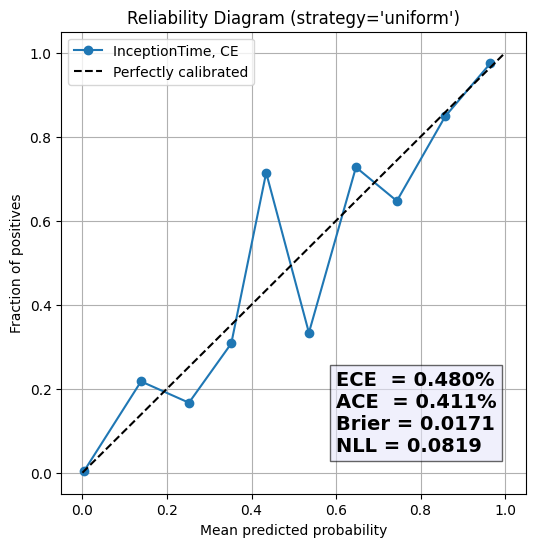

In [342]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

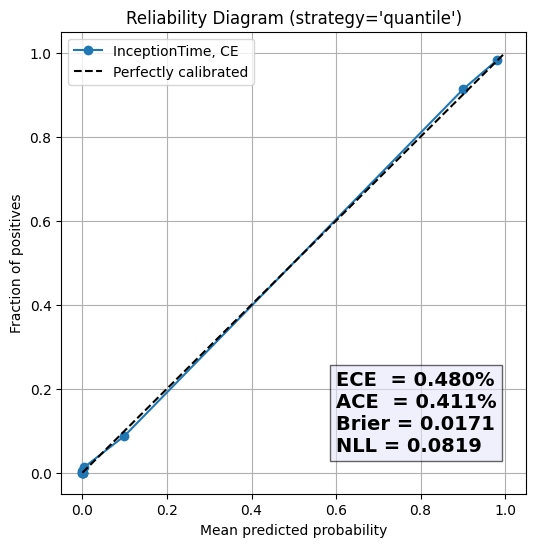

In [343]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [344]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00480
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    13 | [  0.500,   0.600] |      0.552  |      0.308 |       0.244  |     0.00138
 6  |    24 | [  0.600,   0.700] |      0.647  |      0.708 |       0.061  |     0.00063
 7  |    35 | [  0.700,   0.800] |      0.746  |      0.743 |       0.003  |     0.00005
 8  |    56 | [  0.800,   0.900] |      0.860  |      0.821 |       0.038  |     0.00093
 9  |  2172 | [  0.900,   1.000] |      0.991  |      0.993 |       0.002  |     0.00181


In [345]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00411

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00101, 0.03479] |    0.019   |   0.017  |    0.001
 1  |   230 | [0.03508, 0.41016] |    0.099   |   0.087  |    0.012
 2  |   230 | [0.45689, 0.99181] |    0.901   |   0.913  |    0.012
 3  |   230 | [0.99181, 0.99796] |    0.996   |   0.987  |    0.009
 4  |   230 | [0.99798, 0.99921] |    0.999   |   1.000  |    0.001
 5  |   230 | [0.99922, 0.99960] |    0.999   |   1.000  |    0.001
 6  |   230 | [0.99960, 0.99975] |    1.000   |   1.000  |    0.000
 7  |   230 | [0.99975, 0.99984] |    1.000   |   0.996  |    0.004
 8  |   230 | [0.99984, 0.99990] |    1.000   |   1.000  |    0.000
 9  |   230 | [0.99990, 0.99998] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [346]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


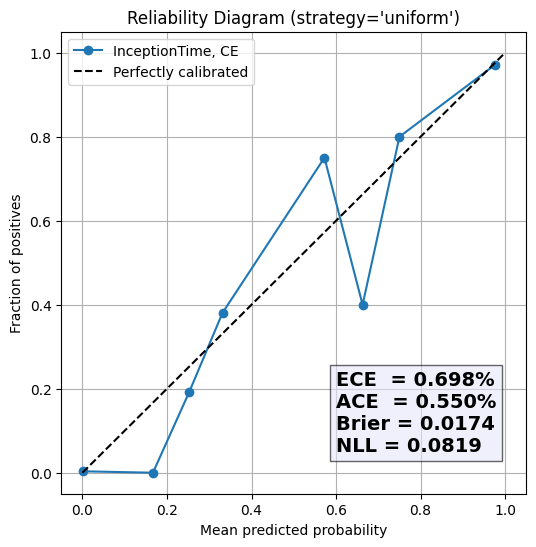

In [347]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [349]:
bins = np.linspace(0.0, 1.0, 11) 

counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)

print("Bin range  | Count")
print("-----------+--------")
for left, right, count in zip(bin_edges[:-1], bin_edges[1:], counts):
    print(f"[{left:.1f}, {right:.1f}) | {count:6d}")


Bin range  | Count
-----------+--------
[0.0, 0.1) |   1766
[0.1, 0.2) |      1
[0.2, 0.3) |     52
[0.3, 0.4) |     21
[0.4, 0.5) |      0
[0.5, 0.6) |     20
[0.6, 0.7) |      5
[0.7, 0.8) |     20
[0.8, 0.9) |      0
[0.9, 1.0) |    415


In [350]:
p = p_test_calibrated[:, 1]
mask = (p > 0.1) & (p < 0.2)
indices = np.where(mask)[0]          # positions in dataset
label = y_test[mask] 
print(f'prob = {p[mask]}, label = {label}')



prob = [0.1668119], label = [0]


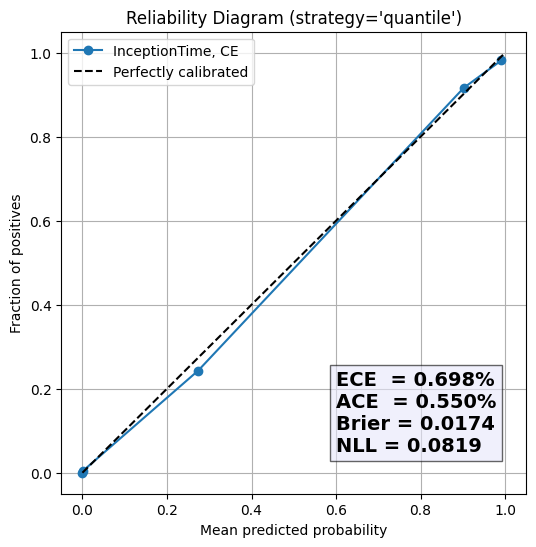

In [351]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

# Mamba2 + CE Loss

In [363]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

torch.Size([8050, 1, 178])
in_channel: 1, sequence_length: 178, n_output: 2


In [364]:
from baseline import Mamba2Classifier, train
print(X_train_tensor.shape)

torch.Size([8050, 1, 178])


In [365]:
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [366]:
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_CE_projconv.pth", weights_only=True))


<All keys matched successfully>

In [367]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([2300, 178, 1])
torch.Size([8050, 178, 1])


In [368]:
#Mamba2
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9815    0.9744    0.9779      6440
           1     0.9004    0.9267    0.9134      1610

    accuracy                         0.9648      8050
   macro avg     0.9410    0.9505    0.9457      8050
weighted avg     0.9653    0.9648    0.9650      8050

[[6275  165]
 [ 118 1492]]


In [369]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9846    0.9761    0.9803       920
           1     0.9076    0.9391    0.9231       230

    accuracy                         0.9687      1150
   macro avg     0.9461    0.9576    0.9517      1150
weighted avg     0.9692    0.9687    0.9689      1150

[[898  22]
 [ 14 216]]


In [370]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9825    0.9755    0.9790      1840
           1     0.9049    0.9304    0.9175       460

    accuracy                         0.9665      2300
   macro avg     0.9437    0.9530    0.9482      2300
weighted avg     0.9670    0.9665    0.9667      2300

[[1795   45]
 [  32  428]]


In [371]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 717
In percentage: 0.8907
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 109
In percentage: 0.9478
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 218
In percentage: 0.9478


## Calibration

In [372]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.9886171 , 0.01138294],
       [0.63570637, 0.36429366],
       [0.9934928 , 0.00650724],
       ...,
       [0.05233132, 0.94766873],
       [0.18038507, 0.81961495],
       [0.99854493, 0.00145513]], shape=(2300, 2), dtype=float32)

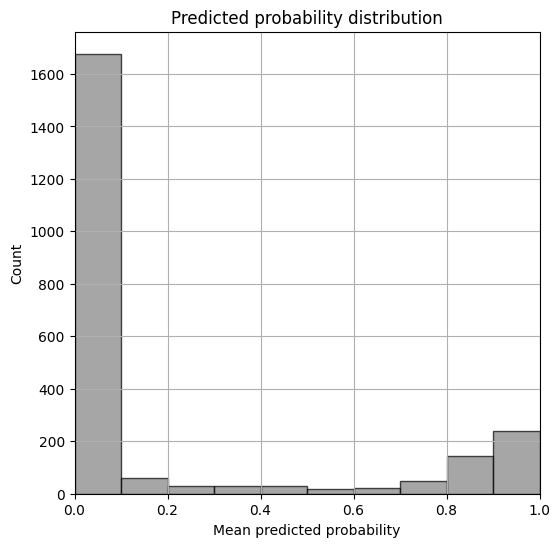

In [373]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

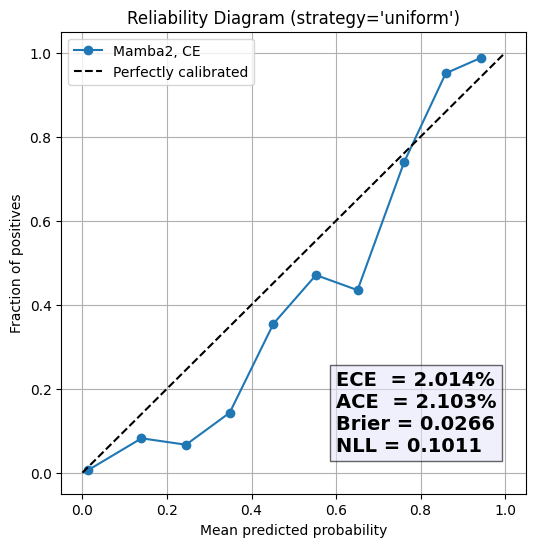

In [374]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

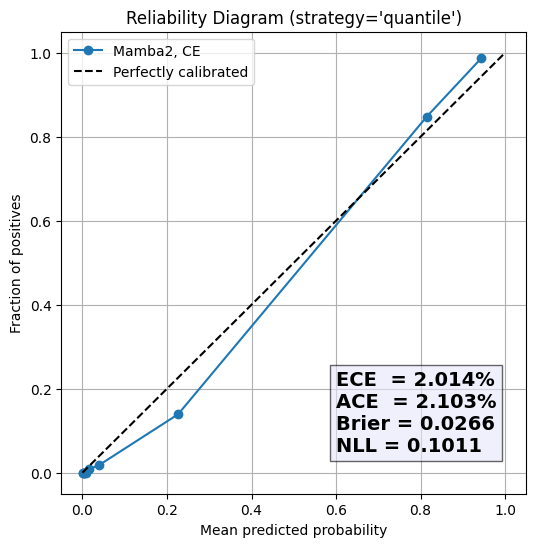

In [375]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

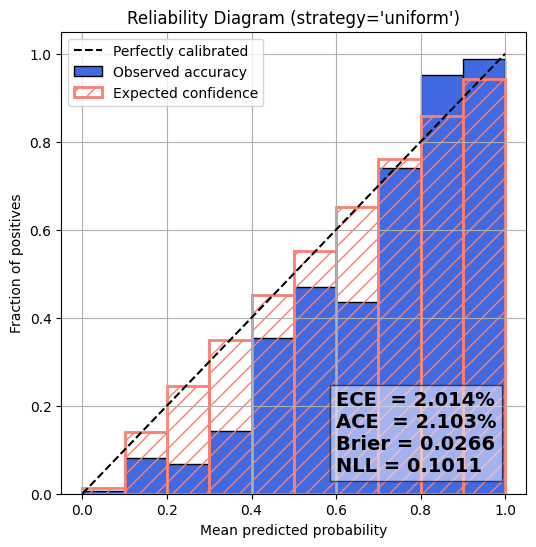

In [376]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [377]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.663


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [378]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

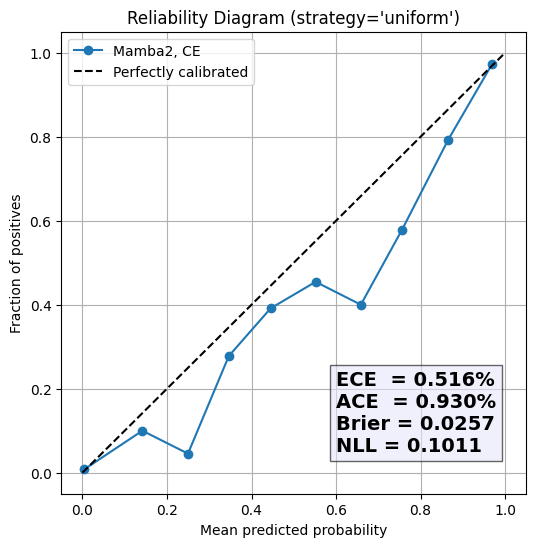

In [379]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [380]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [381]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00516
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    34 | [  0.500,   0.600] |      0.554  |      0.559 |       0.005  |     0.00007
 6  |    33 | [  0.600,   0.700] |      0.656  |      0.576 |       0.080  |     0.00115
 7  |    41 | [  0.700,   0.800] |      0.753  |      0.780 |       0.027  |     0.00049
 8  |    88 | [  0.800,   0.900] |      0.863  |      0.830 |       0.033  |     0.00128
 9  |  2104 | [  0.900,   1.000] |      0.991  |      0.989 |       0.002  |     0.00217


In [382]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00930

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00039, 0.03191] |    0.015   |   0.013  |    0.002
 1  |   230 | [0.03232, 0.37980] |    0.107   |   0.152  |    0.045
 2  |   230 | [0.38380, 0.98300] |    0.833   |   0.861  |    0.028
 3  |   230 | [0.98301, 0.99679] |    0.992   |   0.983  |    0.009
 4  |   230 | [0.99681, 0.99893] |    0.998   |   0.991  |    0.007
 5  |   230 | [0.99893, 0.99955] |    0.999   |   1.000  |    0.001
 6  |   230 | [0.99955, 0.99977] |    1.000   |   1.000  |    0.000
 7  |   230 | [0.99977, 0.99988] |    1.000   |   1.000  |    0.000
 8  |   230 | [0.99988, 0.99993] |    1.000   |   1.000  |    0.000
 9  |   230 | [0.99993, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [383]:
from sklearn.linear_model import LogisticRegression
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

In [384]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

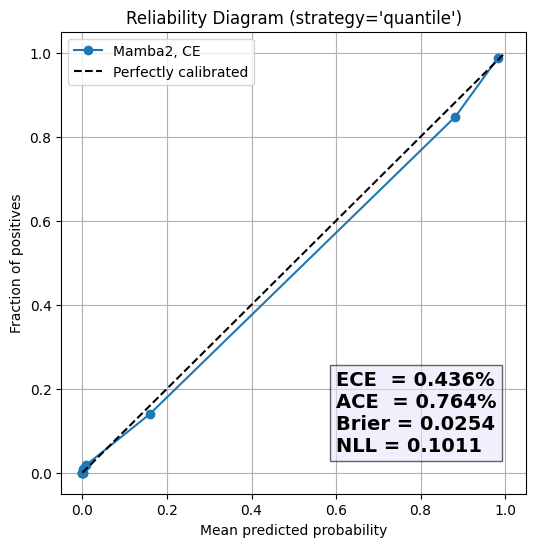

In [385]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [386]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00436
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    28 | [  0.500,   0.600] |      0.552  |      0.429 |       0.123  |     0.00150
 6  |    37 | [  0.600,   0.700] |      0.645  |      0.622 |       0.024  |     0.00038
 7  |    42 | [  0.700,   0.800] |      0.750  |      0.762 |       0.012  |     0.00022
 8  |    95 | [  0.800,   0.900] |      0.859  |      0.853 |       0.006  |     0.00026
 9  |  2098 | [  0.900,   1.000] |      0.991  |      0.989 |       0.002  |     0.00199


In [387]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00764

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00046, 0.03610] |    0.017   |   0.013  |    0.004
 1  |   230 | [0.03655, 0.40290] |    0.118   |   0.152  |    0.034
 2  |   230 | [0.40694, 0.98381] |    0.841   |   0.861  |    0.020
 3  |   230 | [0.98382, 0.99689] |    0.992   |   0.983  |    0.010
 4  |   230 | [0.99691, 0.99895] |    0.998   |   0.991  |    0.007
 5  |   230 | [0.99896, 0.99956] |    0.999   |   1.000  |    0.001
 6  |   230 | [0.99956, 0.99977] |    1.000   |   1.000  |    0.000
 7  |   230 | [0.99977, 0.99988] |    1.000   |   1.000  |    0.000
 8  |   230 | [0.99988, 0.99993] |    1.000   |   1.000  |    0.000
 9  |   230 | [0.99993, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [388]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


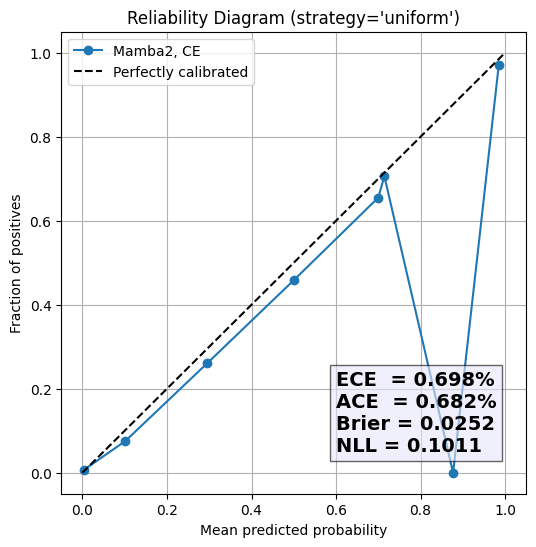

In [389]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [390]:
bins = np.linspace(0.0, 1.0, 11) 

counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)

print("Bin range  | Count")
print("-----------+--------")
for left, right, count in zip(bin_edges[:-1], bin_edges[1:], counts):
    print(f"[{left:.1f}, {right:.1f}) | {count:6d}")


Bin range  | Count
-----------+--------
[0.0, 0.1) |   1721
[0.1, 0.2) |     40
[0.2, 0.3) |     73
[0.3, 0.4) |      0
[0.4, 0.5) |      0
[0.5, 0.6) |     24
[0.6, 0.7) |     29
[0.7, 0.8) |     17
[0.8, 0.9) |      1
[0.9, 1.0) |    395


In [391]:
p = p_test_calibrated[:, 1]
mask = (p > 0.8) & (p < 0.9)
indices = np.where(mask)[0]          # positions in dataset
label = y_test[mask] 
print(f'prob = {p[mask]}, label = {label}')

prob = [0.8768419], label = [0]


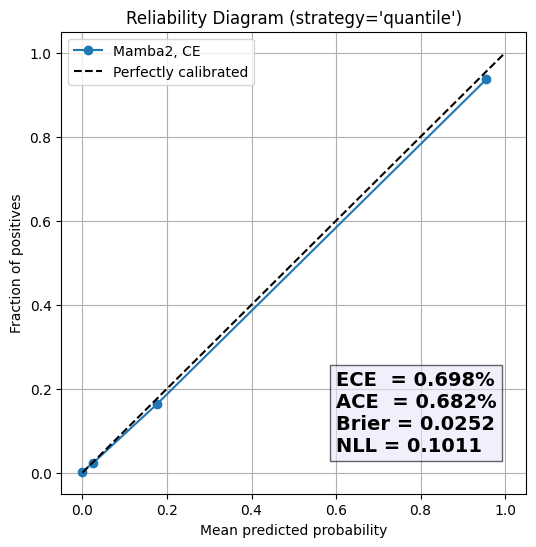

In [392]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [393]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00698
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |    24 | [  0.400,   0.500] |      0.500  |      0.542 |       0.042  |     0.00043
 6  |    29 | [  0.600,   0.700] |      0.700  |      0.655 |       0.045  |     0.00057
 7  |    90 | [  0.700,   0.800] |      0.707  |      0.733 |       0.026  |     0.00103
 8  |    41 | [  0.800,   0.900] |      0.898  |      0.902 |       0.004  |     0.00007
 9  |  2116 | [  0.900,   1.000] |      0.993  |      0.988 |       0.005  |     0.00488


In [394]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00682

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00000] |    0.000   |   0.026  |    0.026
 1  |   230 | [0.00000, 0.50000] |    0.125   |   0.135  |    0.010
 2  |   230 | [0.50000, 0.97297] |    0.851   |   0.865  |    0.014
 3  |   230 | [0.97297, 1.00000] |    0.991   |   0.991  |    0.000
 4  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004
 9  |   230 | [1.00000, 1.00000] |    1.000   |   0.991  |    0.009

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + CE Loss

In [395]:
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 1, 178])


In [396]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 178, n_output: 2


In [397]:
from baseline import Conv_Net
model = Conv_Net(in_channel, seq_length, n_hidden, n_output, dropout=0.1)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5696, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.1, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5696, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [398]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

print(ce_weight)

tensor([0.5556, 5.0000], device='cuda:0')


In [399]:
model.load_state_dict(torch.load("models/epilepsy_cnn_crossent.pth", weights_only=True))

<All keys matched successfully>

In [400]:
model.eval()
logits_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(logits_train, 1)[1]

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9632    0.9793    0.9712      6440
           1     0.9115    0.8503    0.8798      1610

    accuracy                         0.9535      8050
   macro avg     0.9373    0.9148    0.9255      8050
weighted avg     0.9528    0.9535    0.9529      8050

[[6307  133]
 [ 241 1369]]


In [401]:
model.eval()
logits_val = model(X_val_tensor.to(device)).cpu().detach()
preds_val = torch.max(logits_val, 1)[1]

print(classification_report(y_val, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9678    0.9804    0.9741       920
           1     0.9174    0.8696    0.8929       230

    accuracy                         0.9583      1150
   macro avg     0.9426    0.9250    0.9335      1150
weighted avg     0.9577    0.9583    0.9578      1150

[[902  18]
 [ 30 200]]


In [402]:
model.eval()
logits_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.max(logits_test, 1)[1]

print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9651    0.9783    0.9717      1840
           1     0.9080    0.8587    0.8827       460

    accuracy                         0.9543      2300
   macro avg     0.9366    0.9185    0.9272      2300
weighted avg     0.9537    0.9543    0.9539      2300

[[1800   40]
 [  65  395]]


In [403]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 673
In percentage: 0.8360
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 100
In percentage: 0.8696
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 198
In percentage: 0.8609


## Calibration

In [404]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.9061985 , 0.09380152],
       [0.73626804, 0.26373202],
       [0.8903632 , 0.10963677],
       ...,
       [0.13143402, 0.8685659 ],
       [0.11970448, 0.8802955 ],
       [0.94519514, 0.05480484]], shape=(2300, 2), dtype=float32)

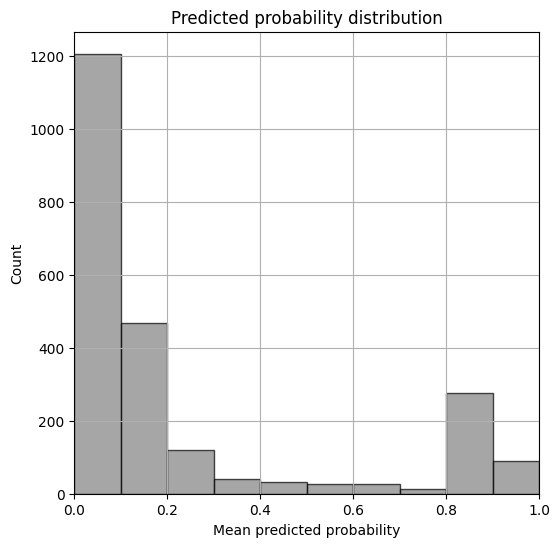

In [405]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

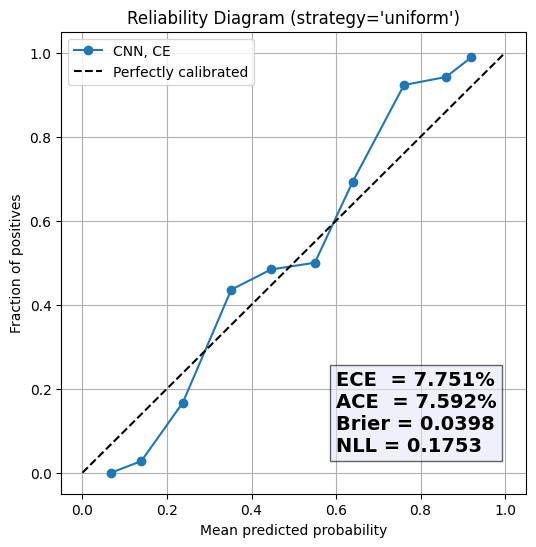

In [406]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

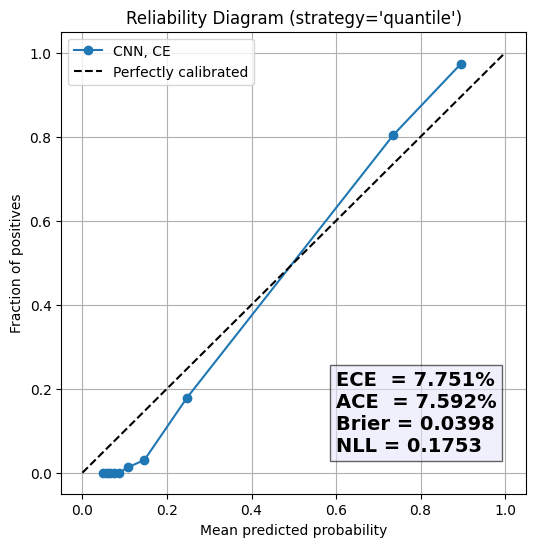

In [407]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [408]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [409]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.533


ModelWithTemperature(
  (model): Conv_Net(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=5696, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
    (features): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.1, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=5696, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, o

In [410]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

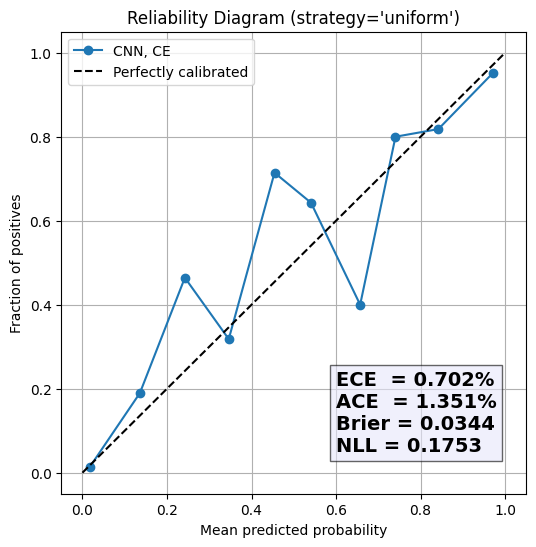

In [413]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

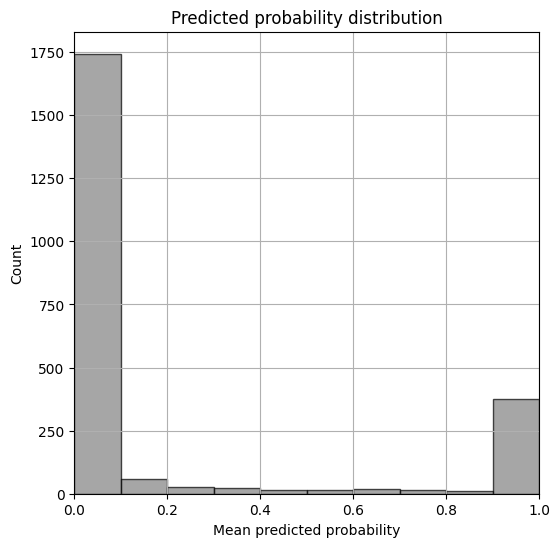

In [412]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

In [414]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [415]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00702
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    28 | [  0.500,   0.600] |      0.543  |      0.464 |       0.079  |     0.00096
 6  |    42 | [  0.600,   0.700] |      0.655  |      0.548 |       0.108  |     0.00197
 7  |    43 | [  0.700,   0.800] |      0.752  |      0.628 |       0.124  |     0.00231
 8  |    69 | [  0.800,   0.900] |      0.861  |      0.812 |       0.049  |     0.00147
 9  |  2118 | [  0.900,   1.000] |      0.981  |      0.980 |       0.000  |     0.00031


In [416]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01351

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00259, 0.03153] |    0.018   |   0.026  |    0.008
 1  |   230 | [0.03157, 0.65546] |    0.174   |   0.196  |    0.022
 2  |   230 | [0.65595, 0.94760] |    0.879   |   0.822  |    0.058
 3  |   230 | [0.94780, 0.97537] |    0.964   |   0.970  |    0.006
 4  |   230 | [0.97538, 0.98565] |    0.981   |   0.987  |    0.006
 5  |   230 | [0.98565, 0.98993] |    0.988   |   1.000  |    0.012
 6  |   230 | [0.98994, 0.99236] |    0.991   |   1.000  |    0.009
 7  |   230 | [0.99237, 0.99408] |    0.993   |   1.000  |    0.007
 8  |   230 | [0.99409, 0.99542] |    0.995   |   1.000  |    0.005
 9  |   230 | [0.99543, 0.99799] |    0.996   |   1.000  |    0.004

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [417]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

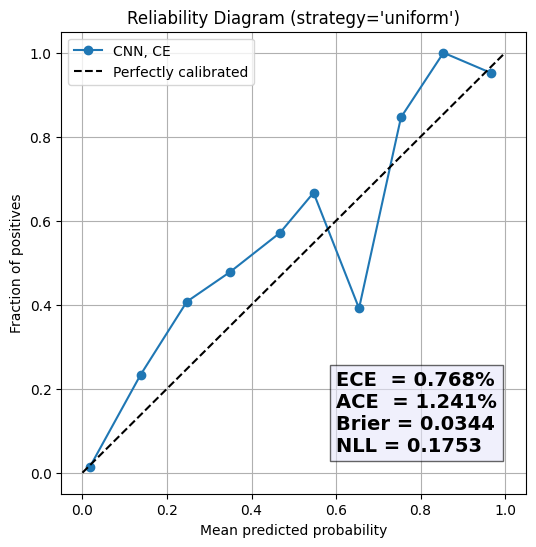

In [418]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [419]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [420]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00768
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    26 | [  0.500,   0.600] |      0.539  |      0.538 |       0.001  |     0.00001
 6  |    46 | [  0.600,   0.700] |      0.652  |      0.457 |       0.196  |     0.00392
 7  |    40 | [  0.700,   0.800] |      0.753  |      0.675 |       0.078  |     0.00136
 8  |    69 | [  0.800,   0.900] |      0.861  |      0.797 |       0.064  |     0.00192
 9  |  2119 | [  0.900,   1.000] |      0.980  |      0.980 |       0.001  |     0.00048


In [421]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01241

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00325, 0.03712] |    0.022   |   0.026  |    0.004
 1  |   230 | [0.03717, 0.67198] |    0.186   |   0.196  |    0.009
 2  |   230 | [0.67245, 0.94865] |    0.884   |   0.822  |    0.062
 3  |   230 | [0.94884, 0.97544] |    0.964   |   0.970  |    0.005
 4  |   230 | [0.97545, 0.98551] |    0.981   |   0.987  |    0.006
 5  |   230 | [0.98551, 0.98975] |    0.988   |   1.000  |    0.012
 6  |   230 | [0.98976, 0.99217] |    0.991   |   1.000  |    0.009
 7  |   230 | [0.99218, 0.99390] |    0.993   |   1.000  |    0.007
 8  |   230 | [0.99391, 0.99525] |    0.995   |   1.000  |    0.005
 9  |   230 | [0.99526, 0.99788] |    0.996   |   1.000  |    0.004

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [422]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


In [424]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [425]:
bins = np.linspace(0.0, 1.0, 11) 

counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)

print("Bin range  | Count")
print("-----------+--------")
for left, right, count in zip(bin_edges[:-1], bin_edges[1:], counts):
    print(f"[{left:.1f}, {right:.1f}) | {count:6d}")


Bin range  | Count
-----------+--------
[0.0, 0.1) |   1651
[0.1, 0.2) |    123
[0.2, 0.3) |      1
[0.3, 0.4) |     75
[0.4, 0.5) |      0
[0.5, 0.6) |      1
[0.6, 0.7) |     76
[0.7, 0.8) |     24
[0.8, 0.9) |      0
[0.9, 1.0) |    349


In [426]:
p = p_test_calibrated[:, 1]
mask = (p > 0.2) & (p < 0.3)
indices = np.where(mask)[0]          # positions in dataset
label = y_test[mask] 
print(f'prob = {p[mask]}, label = {label}')
mask = (p > 0.5) & (p < 0.6)
indices = np.where(mask)[0]          # positions in dataset
label = y_test[mask] 
print(f'prob = {p[mask]}, label = {label}')


prob = [0.24330744], label = [0]
prob = [0.55092746], label = [0]


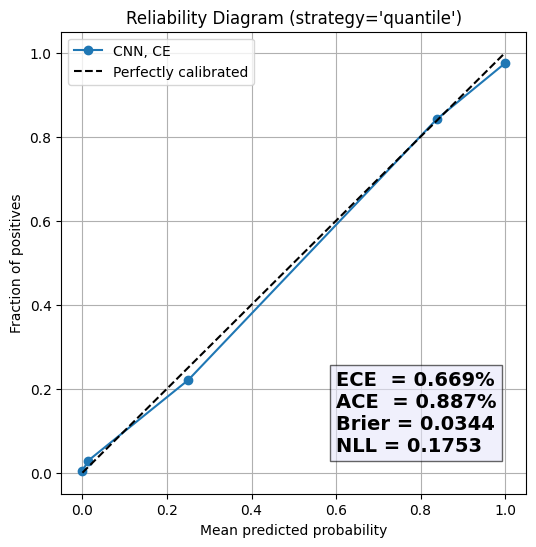

In [427]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [428]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00669
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     1 | [  0.500,   0.600] |      0.551  |      0.000 |       0.551  |     0.00024
 6  |   151 | [  0.600,   0.700] |      0.660  |      0.675 |       0.016  |     0.00102
 7  |    25 | [  0.700,   0.800] |      0.729  |      0.800 |       0.071  |     0.00077
 8  |   123 | [  0.800,   0.900] |      0.828  |      0.829 |       0.002  |     0.00009
 9  |  2000 | [  0.900,   1.000] |      0.993  |      0.988 |       0.005  |     0.00457


In [429]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00887

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.07292] |    0.011   |   0.026  |    0.015
 1  |   230 | [0.07292, 0.62069] |    0.195   |   0.204  |    0.010
 2  |   230 | [0.62069, 0.98630] |    0.797   |   0.813  |    0.016
 3  |   230 | [0.98630, 1.00000] |    0.992   |   0.983  |    0.009
 4  |   230 | [1.00000, 1.00000] |    1.000   |   0.991  |    0.009
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.987  |    0.013
 9  |   230 | [1.00000, 1.00000] |    1.000   |   0.996  |    0.004

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# InceptionTime + PU Loss

In [430]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.tracker import SaveModelCallback

# Try PU problem with CrossEntropyLoss

from sklearn.metrics import f1_score, precision_score
from tsai.metrics import skm_to_fastai

positive_prior = torch.tensor(y_train_pu.mean(), dtype=torch.float32)

f1_macro = skm_to_fastai(f1_score, average="macro")
precision_macro = skm_to_fastai(precision_score, average="macro")
criterion = PULossWrapped(prior=positive_prior, nnPU=True)

X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)

In [431]:
clf.load("epilepsy_inctime_nnpu")

In [432]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(9200, 1, 178)

In [433]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9753    0.9913    0.9832      6440
           1     0.9628    0.8994    0.9300      1610

    accuracy                         0.9729      8050
   macro avg     0.9690    0.9453    0.9566      8050
weighted avg     0.9728    0.9729    0.9726      8050

[[6384   56]
 [ 162 1448]]


In [434]:
logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9786    0.9935    0.9860       920
           1     0.9722    0.9130    0.9417       230

    accuracy                         0.9774      1150
   macro avg     0.9754    0.9533    0.9638      1150
weighted avg     0.9773    0.9774    0.9771      1150

[[914   6]
 [ 20 210]]


In [435]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9866    0.8870    0.9341      2070
           1     0.4670    0.8913    0.6129       230

    accuracy                         0.8874      2300
   macro avg     0.7268    0.8891    0.7735      2300
weighted avg     0.9346    0.8874    0.9020      2300

[[1836  234]
 [  25  205]]


In [436]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 711
In percentage: 0.8832
Test
Total number of true positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 210
In percentage: 0.9130
Val
Total number of true positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 105
In percentage: 0.9130


## Calibration

In [439]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.8317524 , 0.16824761],
       [0.8126226 , 0.18737738],
       [0.97468907, 0.02531091],
       ...,
       [0.23988602, 0.76011395],
       [0.14796415, 0.8520358 ],
       [0.98775357, 0.01224646]], shape=(2300, 2), dtype=float32)

In [440]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

In [441]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

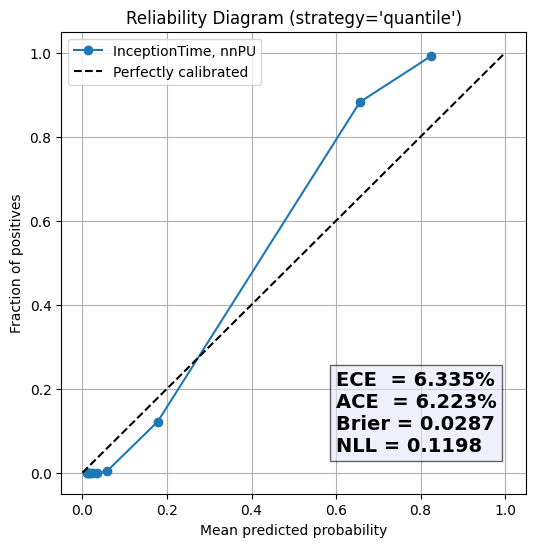

In [442]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [443]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [446]:
from calibration import *
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.419


ModelWithTemperature()

In [447]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

In [448]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [449]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

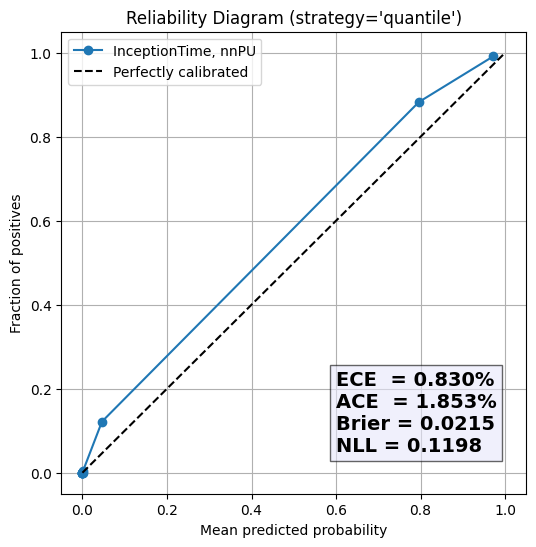

In [450]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [451]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00830
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    23 | [  0.500,   0.600] |      0.550  |      0.348 |       0.202  |     0.00202
 6  |    28 | [  0.600,   0.700] |      0.654  |      0.464 |       0.190  |     0.00231
 7  |    37 | [  0.700,   0.800] |      0.764  |      0.757 |       0.007  |     0.00011
 8  |   108 | [  0.800,   0.900] |      0.858  |      0.907 |       0.049  |     0.00231
 9  |  2104 | [  0.900,   1.000] |      0.992  |      0.990 |       0.002  |     0.00154


In [452]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01853

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00075, 0.05790] |    0.028   |   0.009  |    0.020
 1  |   230 | [0.05875, 0.67977] |    0.204   |   0.117  |    0.087
 2  |   230 | [0.68328, 0.99673] |    0.954   |   0.878  |    0.075
 3  |   230 | [0.99674, 0.99939] |    0.999   |   0.996  |    0.003
 4  |   230 | [0.99940, 0.99977] |    1.000   |   1.000  |    0.000
 5  |   230 | [0.99977, 0.99989] |    1.000   |   1.000  |    0.000
 6  |   230 | [0.99989, 0.99994] |    1.000   |   1.000  |    0.000
 7  |   230 | [0.99994, 0.99996] |    1.000   |   1.000  |    0.000
 8  |   230 | [0.99996, 0.99997] |    1.000   |   1.000  |    0.000
 9  |   230 | [0.99997, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [453]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

In [454]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [455]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [456]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.4f}  |  {weighted:10.5f}")

ECE = 0.00582
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    18 | [  0.500,   0.600] |      0.561  |      0.778 |      0.2170  |     0.00170
 6  |    25 | [  0.600,   0.700] |      0.651  |      0.640 |      0.0107  |     0.00012
 7  |    41 | [  0.700,   0.800] |      0.750  |      0.707 |      0.0427  |     0.00076
 8  |    55 | [  0.800,   0.900] |      0.858  |      0.745 |      0.1129  |     0.00270
 9  |  2161 | [  0.900,   1.000] |      0.992  |      0.992 |      0.0006  |     0.00055


In [457]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.4f}")
    print()

ACE = 0.00340

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00036, 0.02384] |    0.012   |   0.009  |   0.0030
 1  |   230 | [0.02419, 0.42194] |    0.098   |   0.117  |   0.0199
 2  |   230 | [0.42573, 0.98844] |    0.885   |   0.878  |   0.0072
 3  |   230 | [0.98849, 0.99768] |    0.995   |   0.996  |   0.0010
 4  |   230 | [0.99770, 0.99908] |    0.999   |   1.000  |   0.0015
 5  |   230 | [0.99908, 0.99955] |    0.999   |   1.000  |   0.0006
 6  |   230 | [0.99955, 0.99973] |    1.000   |   1.000  |   0.0003
 7  |   230 | [0.99973, 0.99983] |    1.000   |   1.000  |   0.0002
 8  |   230 | [0.99983, 0.99989] |    1.000   |   1.000  |   0.0001
 9  |   230 | [0.99989, 0.99996] |    1.000   |   1.000  |   0.0001

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [458]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


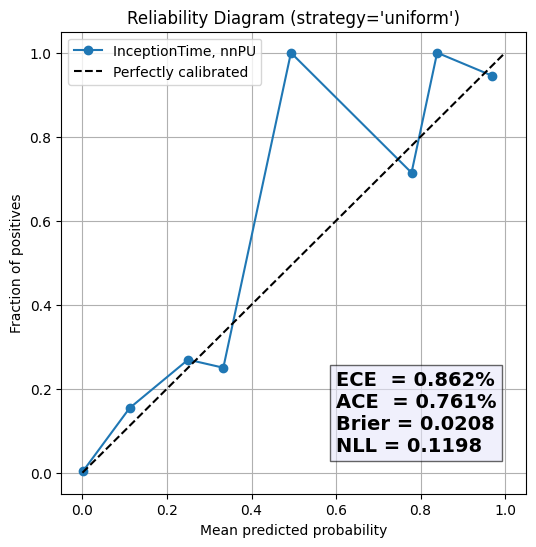

In [459]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [460]:
bins = np.linspace(0.0, 1.0, 11) 

counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)

print("Bin range  | Count")
print("-----------+--------")
for left, right, count in zip(bin_edges[:-1], bin_edges[1:], counts):
    print(f"[{left:.1f}, {right:.1f}) | {count:6d}")


Bin range  | Count
-----------+--------
[0.0, 0.1) |   1733
[0.1, 0.2) |     65
[0.2, 0.3) |     26
[0.3, 0.4) |     12
[0.4, 0.5) |      1
[0.5, 0.6) |      0
[0.6, 0.7) |      0
[0.7, 0.8) |     21
[0.8, 0.9) |      2
[0.9, 1.0) |    440


In [461]:
p = p_test_calibrated[:, 1]
mask = (p > 0.4) & (p < 0.5)
indices = np.where(mask)[0]          # positions in dataset
label = y_test[mask] 
print(f'prob = {p[mask]}, label = {label}')



prob = [0.49329677], label = [1]


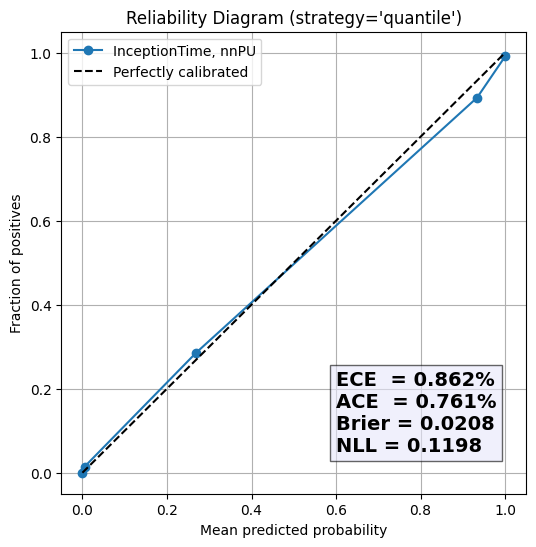

In [462]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [463]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00862
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     1 | [  0.500,   0.600] |      0.507  |      0.000 |       0.507  |     0.00022
 6  |    12 | [  0.600,   0.700] |      0.667  |      0.750 |       0.083  |     0.00043
 7  |    47 | [  0.700,   0.800] |      0.763  |      0.723 |       0.039  |     0.00080
 8  |    67 | [  0.800,   0.900] |      0.887  |      0.851 |       0.036  |     0.00105
 9  |  2173 | [  0.900,   1.000] |      0.993  |      0.986 |       0.006  |     0.00610


In [464]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00761

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.04348] |    0.000   |   0.009  |    0.008
 1  |   230 | [0.04348, 0.22222] |    0.078   |   0.117  |    0.039
 2  |   230 | [0.22222, 0.99495] |    0.907   |   0.896  |    0.012
 3  |   230 | [0.99495, 0.99495] |    0.995   |   0.983  |    0.012
 4  |   230 | [0.99495, 1.00000] |    0.999   |   0.996  |    0.003
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Mamba2 + PU Loss

In [49]:
batch_size = 128
X_train_tensor = X_train_tensor.unsqueeze(1)
X_val_tensor = X_val_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

torch.Size([8050, 1, 178])
in_channel: 1, sequence_length: 178, n_output: 2


In [54]:
from baseline import Mamba2Classifier, train, PULoss
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=1, num_layers=2, dropout=0.3)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): Identity()
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), ep

In [55]:
model_mamba.load_state_dict(torch.load("models/epilepsy_mamba2_pu_projconv.pth", weights_only=True))


<All keys matched successfully>

In [56]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([2300, 178, 1])
torch.Size([8050, 178, 1])


In [85]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_train.append(preds.cpu())
        logits_train.append(probs.cpu())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9772    0.9596    0.9683      6440
           1     0.8494    0.9106    0.8789      1610

    accuracy                         0.9498      8050
   macro avg     0.9133    0.9351    0.9236      8050
weighted avg     0.9517    0.9498    0.9505      8050

[[6180  260]
 [ 144 1466]]


In [86]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_val.append(preds.cpu())
        logits_val.append(probs.cpu())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9846    0.9707    0.9776       920
           1     0.8889    0.9391    0.9133       230

    accuracy                         0.9643      1150
   macro avg     0.9367    0.9549    0.9454      1150
weighted avg     0.9654    0.9643    0.9647      1150

[[893  27]
 [ 14 216]]


In [87]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_test.append(preds.cpu())
        logits_test.append(probs.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9779    0.9598    0.9687      1840
           1     0.8502    0.9130    0.8805       460

    accuracy                         0.9504      2300
   macro avg     0.9140    0.9364    0.9246      2300
weighted avg     0.9523    0.9504    0.9511      2300

[[1766   74]
 [  40  420]]


In [62]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 726
In percentage: 0.9019
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 108
In percentage: 0.9391
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 213
In percentage: 0.9261


## Calibration

In [88]:
logits_train = torch.cat([torch.zeros_like(logits_train), logits_train], dim=1)
logits_val = torch.cat([torch.zeros_like(logits_val), logits_val], dim=1)
logits_test = torch.cat([torch.zeros_like(logits_test), logits_test], dim=1)


In [95]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
y_prob_before

array([[0.43555698, 0.56444305],
       [0.45551768, 0.5444823 ],
       [0.4974305 , 0.50256944],
       ...,
       [0.28100458, 0.71899533],
       [0.28066358, 0.71933645],
       [0.49867344, 0.5013265 ]], shape=(2300, 2), dtype=float32)

In [96]:
y_prob_before = torch.sigmoid(torch.tensor(logits_test[:, 1])).numpy()
y_prob_before = np.column_stack([1 - y_prob_before, y_prob_before]) 
n_bins = 10
y_prob_before

array([[0.43555695, 0.56444305],
       [0.4555177 , 0.5444823 ],
       [0.49743056, 0.50256944],
       ...,
       [0.28100467, 0.71899533],
       [0.28066355, 0.71933645],
       [0.4986735 , 0.5013265 ]], shape=(2300, 2), dtype=float32)

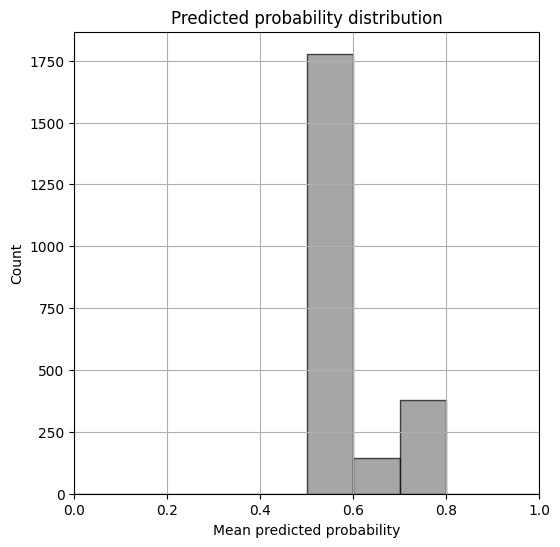

In [97]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

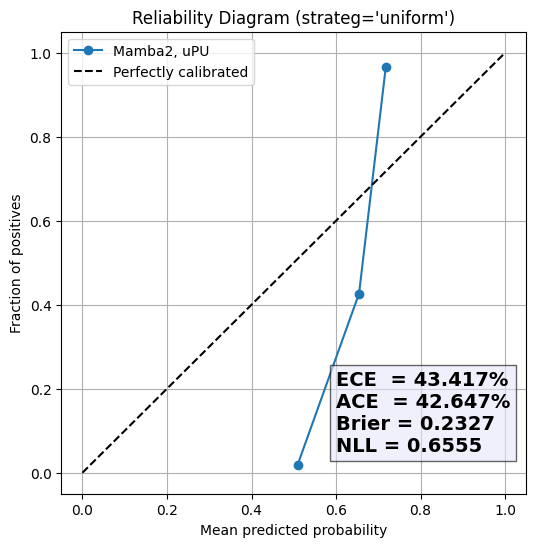

In [98]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strateg=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

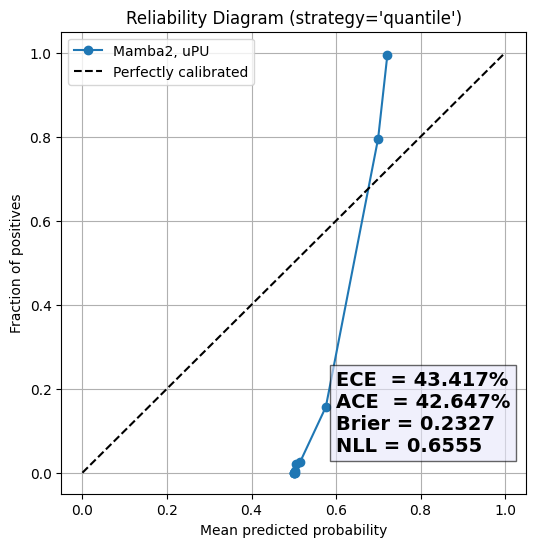

In [99]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [100]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.565


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): Identity()
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=25

In [101]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

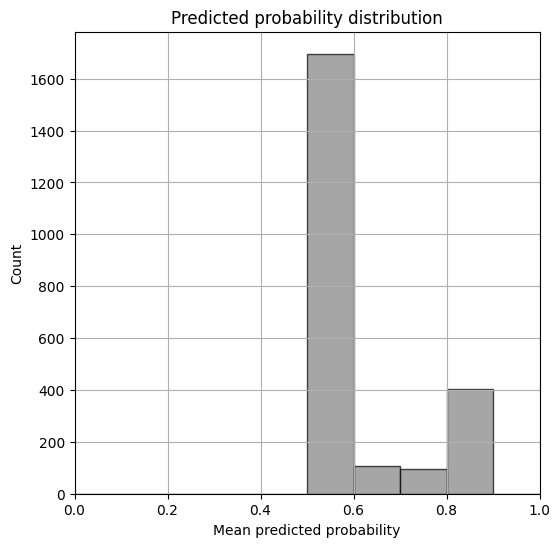

In [102]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

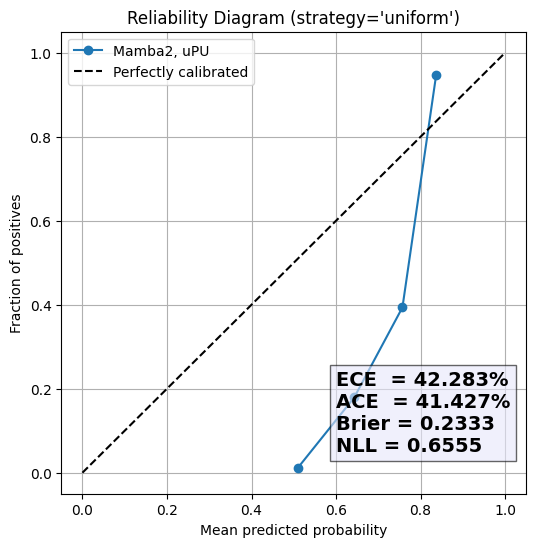

In [103]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Platt Scaling

In [104]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

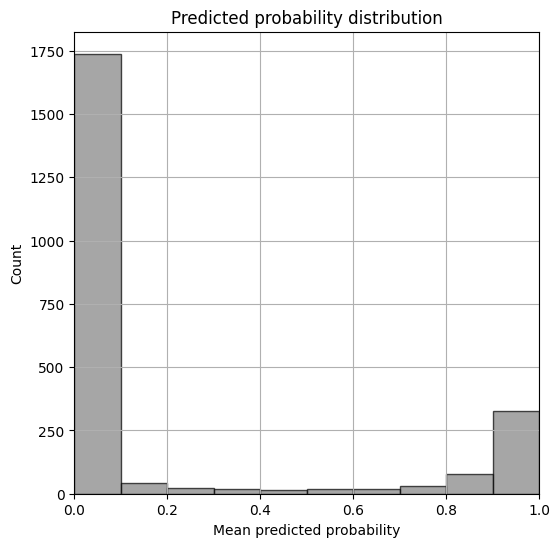

In [107]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

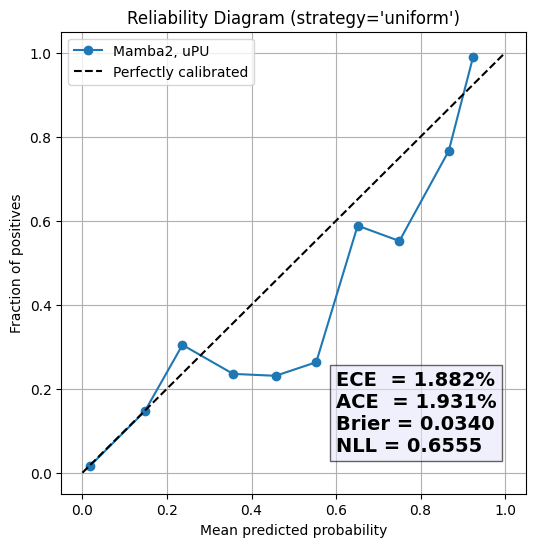

In [105]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

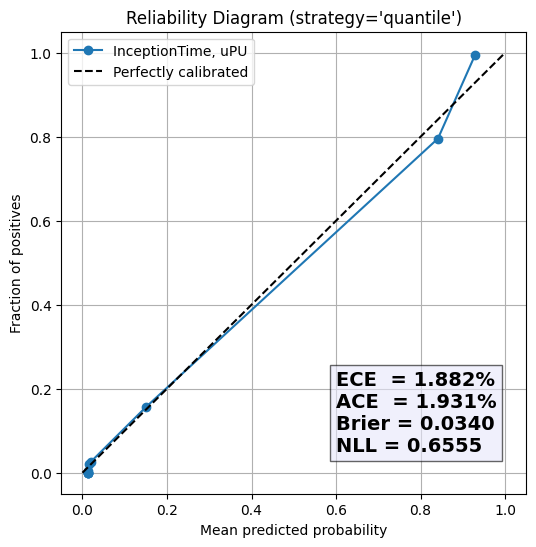

In [108]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [109]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01882
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    32 | [  0.500,   0.600] |      0.549  |      0.469 |       0.080  |     0.00112
 6  |    34 | [  0.600,   0.700] |      0.647  |      0.676 |       0.029  |     0.00043
 7  |    52 | [  0.700,   0.800] |      0.756  |      0.615 |       0.140  |     0.00318
 8  |   118 | [  0.800,   0.900] |      0.862  |      0.797 |       0.065  |     0.00334
 9  |  2064 | [  0.900,   1.000] |      0.973  |      0.985 |       0.012  |     0.01076


In [110]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01931

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.05844, 0.07820] |    0.071   |   0.004  |    0.066
 1  |   230 | [0.07827, 0.45206] |    0.159   |   0.204  |    0.045
 2  |   230 | [0.45810, 0.97109] |    0.850   |   0.843  |    0.006
 3  |   230 | [0.97152, 0.98429] |    0.980   |   0.974  |    0.006
 4  |   230 | [0.98430, 0.98603] |    0.985   |   0.978  |    0.007
 5  |   230 | [0.98603, 0.98653] |    0.986   |   0.996  |    0.009
 6  |   230 | [0.98653, 0.98674] |    0.987   |   1.000  |    0.013
 7  |   230 | [0.98674, 0.98687] |    0.987   |   1.000  |    0.013
 8  |   230 | [0.98687, 0.98697] |    0.987   |   1.000  |    0.013
 9  |   230 | [0.98697, 0.98721] |    0.987   |   1.000  |    0.013

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [111]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  

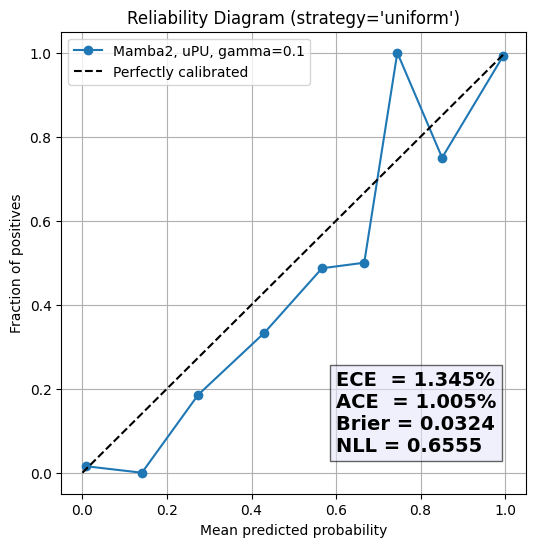

In [112]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

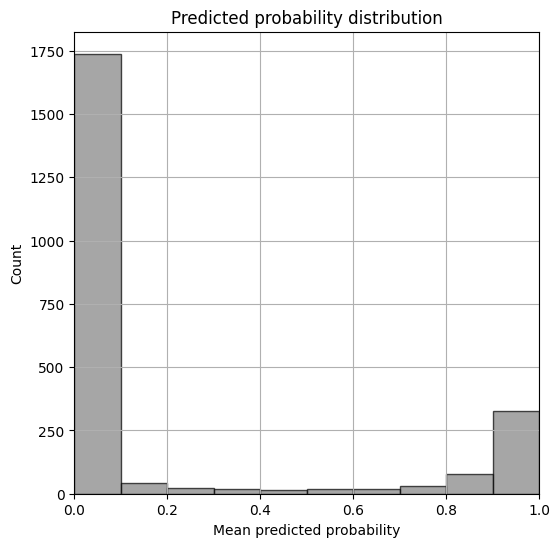

In [117]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

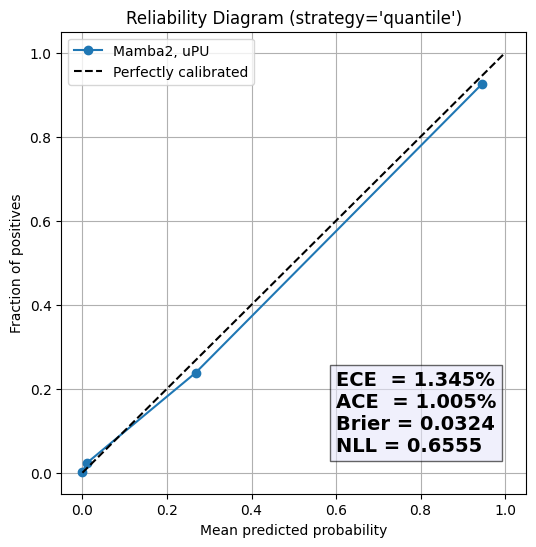

In [113]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [116]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01345
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    97 | [  0.500,   0.600] |      0.567  |      0.526 |       0.042  |     0.00175
 6  |     2 | [  0.600,   0.700] |      0.667  |      0.500 |       0.167  |     0.00014
 7  |    71 | [  0.700,   0.800] |      0.726  |      0.817 |       0.091  |     0.00280
 8  |    53 | [  0.800,   0.900] |      0.851  |      0.755 |       0.096  |     0.00222
 9  |  2077 | [  0.900,   1.000] |      0.993  |      0.986 |       0.007  |     0.00654


In [115]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01005

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.00000] |    0.000   |   0.004  |    0.004
 1  |   230 | [0.00000, 0.44000] |    0.171   |   0.222  |    0.050
 2  |   230 | [0.44000, 0.98947] |    0.822   |   0.835  |    0.013
 3  |   230 | [0.98947, 0.98947] |    0.989   |   0.974  |    0.016
 4  |   230 | [0.98947, 0.98947] |    0.989   |   0.974  |    0.016
 5  |   230 | [0.98947, 1.00000] |    0.997   |   0.991  |    0.006
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + PU Loss

In [118]:
y_train_pu_tensor = torch.tensor(np.where(y_train_pu == 1, 1, -1), dtype=torch.long)
y_val_tensor = torch.tensor(np.where(y_val == 1, 1, -1), dtype=torch.long)
y_test_tensor = torch.tensor(np.where(y_test == 1, 1, -1), dtype=torch.long)
batch_size = 64
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 1, 178])


In [119]:
from baseline import Conv_Net
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5696, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5696, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [124]:
model.load_state_dict(torch.load("models/epilepsy_cnn_nnpu.pth", weights_only=True))

<All keys matched successfully>

In [142]:
model.eval()
with torch.no_grad():
    logits_train = model(X_train_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_train)
    preds_train = (probs > 0.5).long().view(-1)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9291    0.9913    0.9592      6440
           1     0.9525    0.6975    0.8053      1610

    accuracy                         0.9325      8050
   macro avg     0.9408    0.8444    0.8823      8050
weighted avg     0.9338    0.9325    0.9284      8050

[[6384   56]
 [ 487 1123]]


In [143]:
model.eval()
with torch.no_grad():
    logits_val = model(X_val_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_val)
    preds_val = (probs > 0.5).long().view(-1)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9442    0.9935    0.9682       920
           1     0.9670    0.7652    0.8544       230

    accuracy                         0.9478      1150
   macro avg     0.9556    0.8793    0.9113      1150
weighted avg     0.9488    0.9478    0.9455      1150

[[914   6]
 [ 54 176]]


In [144]:
model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_test)
    preds_test = (probs > 0.5).long().view(-1)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9359    0.9924    0.9633      1840
           1     0.9599    0.7283    0.8282       460

    accuracy                         0.9396      2300
   macro avg     0.9479    0.8603    0.8958      2300
weighted avg     0.9407    0.9396    0.9363      2300

[[1826   14]
 [ 125  335]]


In [145]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 550
In percentage: 0.6832
Val
Total number of positive sampels:230
Total number of unmarked positive sampels: 115
Number of unmarked samples correctly predicted as positive: 91
In percentage: 0.7913
Test
Total number of positive sampels:460
Total number of unmarked positive sampels: 230
Number of unmarked samples correctly predicted as positive: 172
In percentage: 0.7478


## Calibration

In [146]:
logits_train = torch.cat([torch.zeros_like(logits_train), logits_train], dim=1)
logits_val = torch.cat([torch.zeros_like(logits_val), logits_val], dim=1)
logits_test = torch.cat([torch.zeros_like(logits_test), logits_test], dim=1)


In [147]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
y_prob_before

array([[0.98758173, 0.01241827],
       [0.96773493, 0.03226512],
       [0.9883837 , 0.01161628],
       ...,
       [0.35189342, 0.6481066 ],
       [0.3189038 , 0.68109626],
       [0.9939744 , 0.00602563]], shape=(2300, 2), dtype=float32)

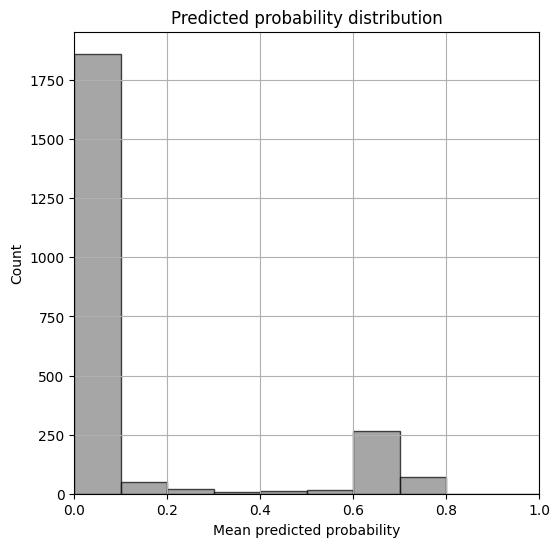

In [148]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

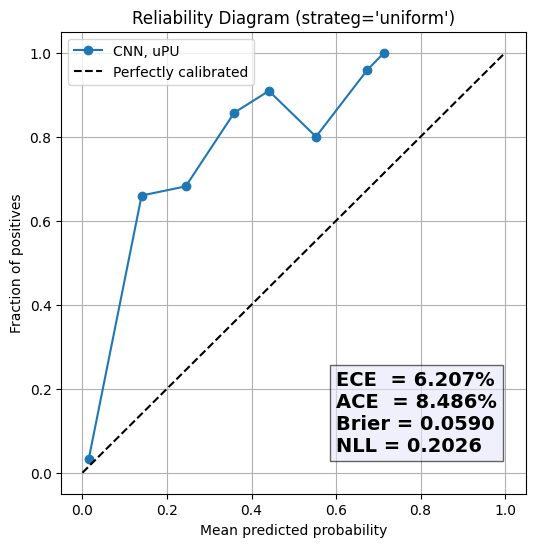

In [149]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strateg=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

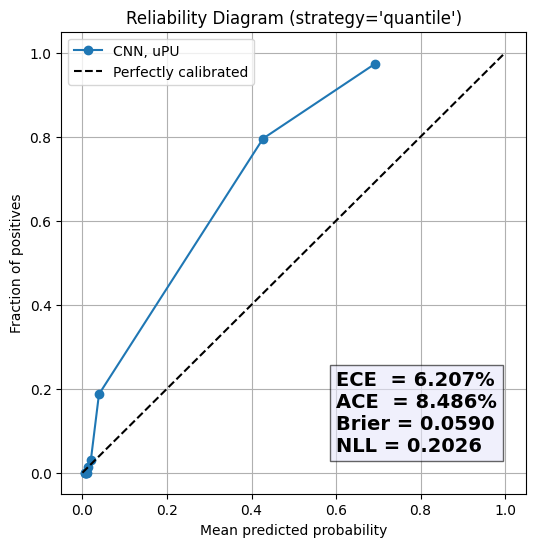

In [150]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [159]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 1.072


ModelWithTemperature(
  (model): Conv_Net(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.5, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=5696, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (features): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.5, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=5696, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, o

In [160]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

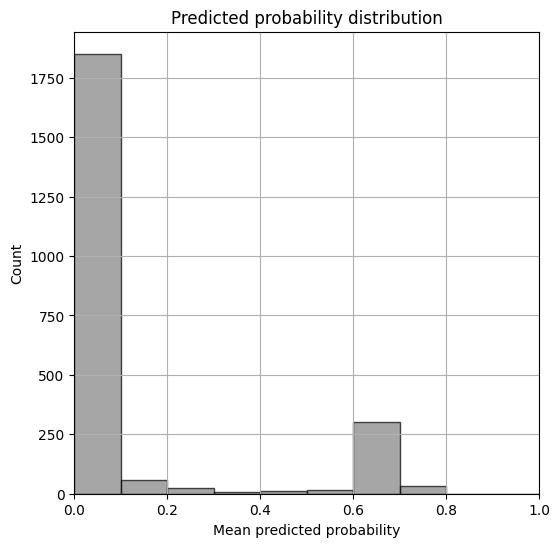

In [161]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

## Platt Scaling

In [162]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(2300, 2)

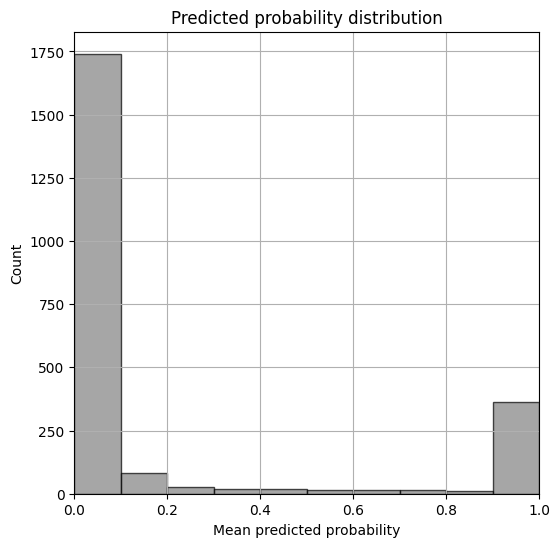

In [163]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

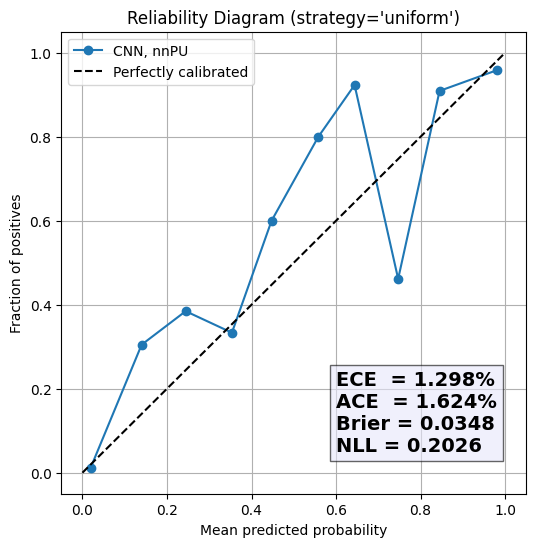

In [166]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

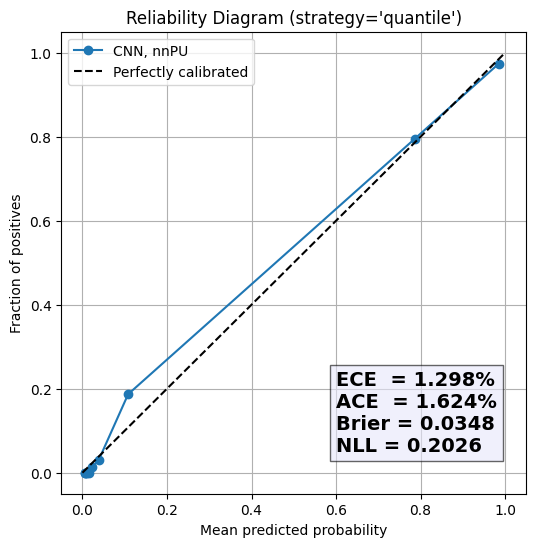

In [167]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [168]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01298
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    35 | [  0.500,   0.600] |      0.555  |      0.571 |       0.017  |     0.00025
 6  |    31 | [  0.600,   0.700] |      0.645  |      0.774 |       0.129  |     0.00174
 7  |    39 | [  0.700,   0.800] |      0.753  |      0.564 |       0.189  |     0.00320
 8  |    93 | [  0.800,   0.900] |      0.858  |      0.720 |       0.138  |     0.00557
 9  |  2102 | [  0.900,   1.000] |      0.980  |      0.983 |       0.002  |     0.00223


In [169]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01624

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00975, 0.01744] |    0.015   |   0.026  |    0.011
 1  |   230 | [0.01746, 0.74301] |    0.213   |   0.204  |    0.009
 2  |   230 | [0.74344, 0.94401] |    0.892   |   0.813  |    0.079
 3  |   230 | [0.94412, 0.97235] |    0.961   |   0.970  |    0.008
 4  |   230 | [0.97239, 0.98224] |    0.978   |   0.987  |    0.009
 5  |   230 | [0.98225, 0.98747] |    0.985   |   1.000  |    0.015
 6  |   230 | [0.98748, 0.99016] |    0.989   |   1.000  |    0.011
 7  |   230 | [0.99016, 0.99214] |    0.991   |   1.000  |    0.009
 8  |   230 | [0.99216, 0.99389] |    0.993   |   1.000  |    0.007
 9  |   230 | [0.99389, 0.99709] |    0.995   |   1.000  |    0.005

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [170]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  

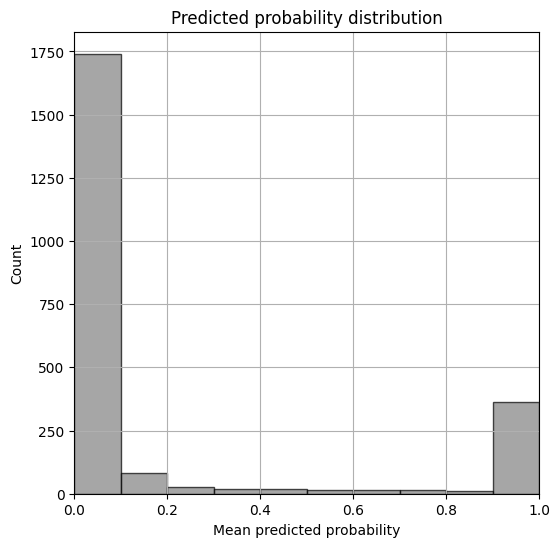

In [172]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

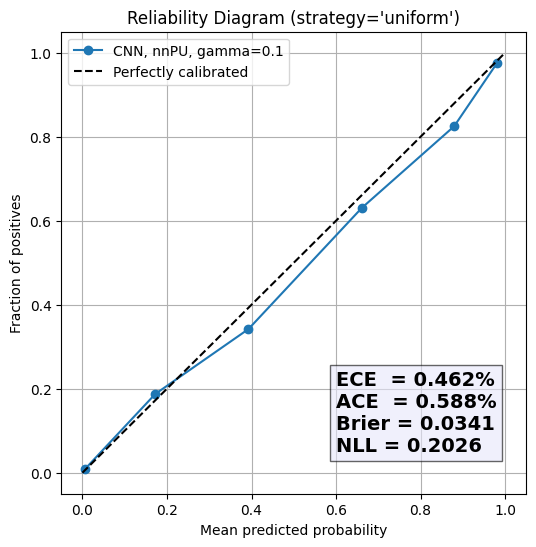

In [171]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

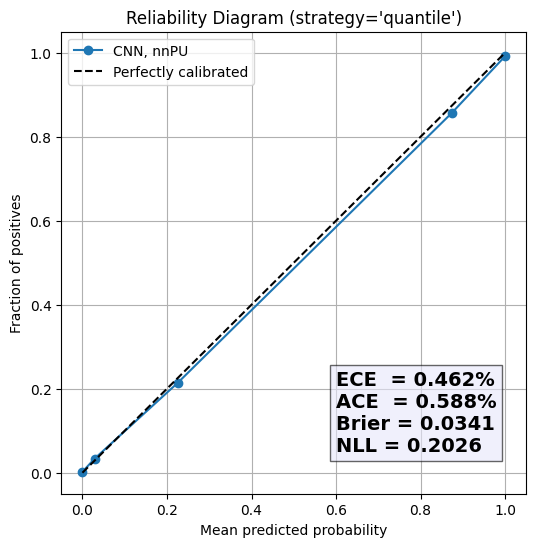

In [173]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [174]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00462
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 6  |   168 | [  0.600,   0.700] |      0.637  |      0.643 |       0.006  |     0.00046
 8  |   104 | [  0.800,   0.900] |      0.848  |      0.817 |       0.030  |     0.00137
 9  |  2028 | [  0.900,   1.000] |      0.991  |      0.988 |       0.003  |     0.00279


In [175]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00588

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   230 | [0.00000, 0.01471] |    0.007   |   0.022  |    0.015
 1  |   230 | [0.01471, 0.60714] |    0.192   |   0.213  |    0.021
 2  |   230 | [0.60714, 0.96154] |    0.804   |   0.809  |    0.005
 3  |   230 | [0.96154, 1.00000] |    0.975   |   0.965  |    0.010
 4  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   230 | [1.00000, 1.00000] |    1.000   |   0.991  |    0.009
 9  |   230 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Calibration Metrics

### **Expected Calibration Error (ECE)**

Let the predictions be divided into $M$ equally spaced bins $B_1, B_2, \dots, B_M$.
.  
The Expected Calibration Error measures the weighted average gap between accuracy and confidence across bins:

$$
\mathrm{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{N} \, \big| \mathrm{acc}(B_m) - \mathrm{conf}(B_m) \big|
$$

where:

$$
\mathrm{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1}(\hat{y}_i = y_i), \quad
\mathrm{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i
$$


---

### **Adaptive Calibration Error (ACE)**

ACE measures the average calibration error across all classes and adaptive (equal-frequency) ranges.  
For each class $k \in \{1, \dots, K\}$, the predicted probabilities $\pi_k(x_i)$ are sorted and divided into $R$ ranges such that each contains approximately the same number of samples.

$$
\mathrm{ACE} = \frac{1}{K R} \sum_{k=1}^{K} \sum_{r=1}^{R}
\big| \mathrm{acc}(r, k) - \mathrm{conf}(r, k) \big|
$$

where

$$
\mathrm{acc}(r, k) = \frac{1}{|B^{(k)}_r|} \sum_{i \in B^{(k)}_r} \mathbf{1}[y_i = k],
\quad
\mathrm{conf}(r, k) = \frac{1}{|B^{(k)}_r|} \sum_{i \in B^{(k)}_r} \pi_k(x_i)
$$

and each $B^{(k)}_r$ represents the $r$-th adaptive bin for class $k$.

---

### **Brier Score**

Measures the mean squared error between predicted probabilities and true binary outcomes:

$$
\mathrm{Brier} = \frac{1}{N} \sum_{i=1}^{N} \big( \hat{p}_i - y_i \big)^2
$$


---

### **Negative Log-Likelihood (NLL)**

Measures the average negative log-probability assigned to the true class:

$$
\mathrm{NLL} = -\frac{1}{N} \sum_{i=1}^{N} 
\Big[
y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i)
\Big]
$$

Lower NLL indicates both better calibration and accuracy.